<a href="https://colab.research.google.com/github/pranav14-cy/Analysis-of-Time-series-Data/blob/main/New_something.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nsepy

  Created wheel for nsepy: filename=nsepy-0.8-py3-none-any.whl size=36085 sha256=54ca3c1796eb43f252709b05135c2322318fddef781e7ad753f192950f41eef2
  Stored in directory: /root/.cache/pip/wheels/32/ab/d9/78ceea14cdf6de83376082b3cb0c2999fd77f823e35c47b9ec
Successfully built nsepy


In [ ]:
!pip install sklearn
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install seaborn

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.6894843050000077
GPU (s):
0.04386927299998433
GPU speedup over CPU: 84x


In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 458.3 MB 10 kB/s 


In [ ]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model,Model
from tensorflow.keras.layers import LSTM, Input, RepeatVector, TimeDistributed,Dense, Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from math import sqrt
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedKFold,cross_val_score
from sklearn.feature_selection import RFECV,RFE,SelectFromModel
from sklearn.tree import DecisionTreeRegressor
from numpy import mean,std
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC,SVR
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
import time
import math

In [ ]:
!pip install yfinance
pip install yfinance

# Modelling and Pre-processing Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/Truinvest/NOTEBOOK/alpha_features.csv')
df = df.rename(columns={"Unnamed: 0":"timestamp"})
df = df.drop('ACOS',axis=1)
df = df.drop('ASIN',axis=1)
df = df.dropna()
train_dates = pd.to_datetime(df['timestamp'][0:int(0.9*df.shape[0])])
train_dates.reset_index(inplace = True, drop = True)
test_dates = pd.to_datetime(df['timestamp'][int(0.9*df.shape[0]):])
test_dates.reset_index(inplace = True, drop = True)
df = df.set_index('timestamp')
df

,open,high,low,close,adj close,volume,1st,2nd,Target,ADX,MACD,MACDSIGNAL,MACDHIST,Momentum,RSI,fastk,fastd,OBV,ATR,NATR,HT_DCPERIOD,sine,leadsine,CORREL,LINEARREG,ADXR,APO,aroondown,aroonup,AROONOSC,BOP,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,TRIX,...,alpha043,alpha044,alpha045,alpha046,alpha047,alpha049,alpha050,alpha051,alpha052,alpha053,alpha054,alpha055,alpha057,alpha060,alpha061,alpha062,alpha064,alpha065,alpha066,alpha068,alpha071,alpha072,alpha073,alpha074,alpha075,alpha077,alpha078,alpha081,alpha083,alpha084,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-29,2.635000,2.636429,2.550714,2.551786,2.191005,490025200,2.638214,2.699167,1,31.705994,0.067939,0.088479,-0.020540,-0.020000,53.069789,0.798296,38.804774,3.527109e+10,0.062285,2.440844,26.125547,-0.837609,-0.978551,0.985572,2.624455,38.436581,0.032443,28.571429,21.428571,-7.142857,-0.970822,-56.496135,6.139578,6.090346,52.509764,25.012689,0.218109,28.256997,0.246399,0.635378,...,64.0,-0.339920,-0.033331,1.000000,1.100820,-0.001320,-0.683385,-0.001320,-0.050935,-1.853156,1.100724e+12,-0.458059,-0.045117,0.000025,True,0,0,0,-1.604607,0,16.0,0.943134,-14.0,0,False,0.097364,0.706164,0,-0.033801,1.643966e-01,0.823973,0,0.172881,1.0,-0.329762,True,-7.0,-0.207908,0,-30.153350
2005-12-30,2.532500,2.586786,2.512143,2.567500,2.204497,624262800,2.667857,2.776309,1,29.628276,0.060487,0.082881,-0.022394,-0.010357,54.629490,32.024737,23.946123,3.589535e+10,0.063168,2.460285,25.119420,-0.931065,-0.916352,0.982771,2.610942,37.843083,0.015870,21.428571,14.285714,-7.142857,0.468899,-82.536321,9.258980,2.617930,45.019523,27.263019,0.241100,25.871981,0.228799,0.627383,...,60.0,0.308910,-0.030701,1.000000,0.016621,-2.547248,-0.385548,-2.547248,0.120089,1.365986,-6.924341e-01,-0.470216,-6.010371,-0.000586,True,-1,0,0,-1.347661,0,15.0,1.122807,-16.0,0,False,0.096414,0.788355,0,-11.332439,1.000000e+00,0.850362,0,0.144146,3.0,-0.021068,True,-7.0,-0.170862,0,0.462700
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.292199,807234400,2.686310,2.866786,1,28.494735,0.062107,0.078726,-0.016619,0.130000,63.192585,91.115778,41.312937,3.670259e+10,0.065952,2.470434,24.235858,-0.998593,-0.743610,0.978838,2.625636,37.538667,0.013530,14.285714,7.142857,-7.142857,0.947999,61.323067,26.385170,13.758703,46.899634,24.247041,0.223879,31.983655,0.295313,0.619430,...,36.0,0.090753,-0.049601,-1.000000,-0.245695,-0.102143,-0.302829,-0.102143,0.120562,-3.588158,-8.512101e-01,-0.826815,-6.568440,-0.000509,True,-1,0,0,-2.327476,0,14.0,1.356560,-13.0,0,False,0.096889,0.815995,0,-32.116704,1.000000e+00,0.927335,0,0.118262,6.0,-0.002200,True,-13.0,-0.146165,0,0.937499
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.298945,619603600,2.699167,2.964881,1,27.956577,0.063295,0.075640,-0.012345,0.128214,63.759199,82.092361,68.410959,3.732219e+10,0.065016,2.428251,23.417971,-0.786213,-0.118977,0.978076,2.637883,36.167588,0.014100,7.142857,100.000000,92.857143,-0.108103,133.448082,27.518399,20.960523,53.865089,22.839016,0.207888,34.952399,0.318147,0.611512,...,42.0,-0.017183,0.094423,1.000000,0.052098,1.000000,-0.347991,1.000000,0.080099,1.876142,-3.209770e-01,-0.885897,-6.928436,-0.000051,True,0,0,0,-1.308478,0,11.0,0.665628,-2.0,-1,False,0.097839,0.705410,0,-45.829646,1.029461e+00,0.868046,0,0.094277,7.0,-0.004207,True,-13.0,-0.024816,0,-0.106096
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.280854,449422400,2.776309,3.021191,1,27.007707,0.061824,0.072876,-0.011053,0.081072,61.045157,71.631551,81.613230,3.687277e+10,0.063485,2.389847,22.574241,0.480515,0.959899,0.973749,2.641072,34.669867,0.017349,0.000000,92.857143,92.857143,-0.391298,74.252849,22.090313,14.672403,61.022325,24.733043,0.219823,33.238923,0.295422,0.603269,...,42.0,-0.036203,-0.047408,1.000000,1.281797,1.000000,-0.393630,1.000000,0.076157,-1.130287,6.888031e+12,-0.930165,-0.045259,0.000252,True,0,0,0,-2.3191

In [ ]:
import numpy as np
from scipy.signal import argrelextrema

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []
    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['close'].idxmin())  
    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]
    p = prices.reset_index()   
    max_min['day_num'] = p[p['timestamp'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['close']
    
    return max_min

smoothing = 3
window = 10
resampled_data = df
#resampled_data['timestamp'] = df.index
minmax = get_max_min(resampled_data, smoothing, window)
minmax


day_num
10        3.056786
19        2.696786
26        2.319643
27        2.311071
34        2.562500
           ...    
3562    144.979996
3571    145.600006
3572    145.860001
3575    151.119995
3589    154.300003
Name: close, Length: 615, dtype: float64

In [ ]:

from collections import defaultdict

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

patterns = find_patterns(minmax)
patterns

defaultdict(list,
            {'IHS': [(566, 584),
              (989, 1034),
              (1125, 1141),
              (1162, 1186),
              (2202, 2230),
              (2627, 2648),
              (2940, 2974)]})

In [ ]:
plt.figure(figsize=(20,10))
resampled_data.reset_index()['close'][-100:].plot()
plt.plot(minmax.index[-12:],minmax.values[-12:],color='blue',alpha=.5)

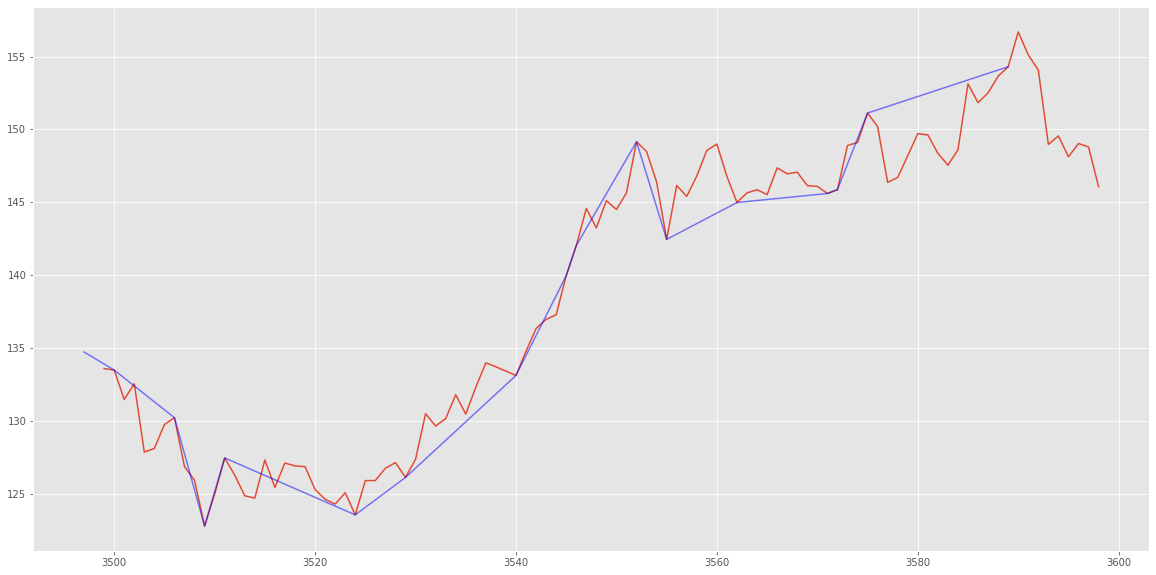

In [ ]:
plt.figure(figsize=(20,10))
resampled_data.reset_index()['close'][-100:].plot()
plt.plot(minmax.index[-17:],minmax.values[-17:],color='blue',alpha=.5)

**Defining Targets and Various trends varying from 1 to 21 days**

In [ ]:
#defining the trend of closing price for the stock
signals = []
for i in range(len(df)-21):
    if(df['close'][i+3]>df['close'][i] and df['close'][i+6]>df['close'][i] and df['close'][i+9]>df['close'][i] and df['close'][i+12]>df['close'][i] and df['close'][i+15]>df['close'][i] and df['close'][i+18]>df['close'][i] and df['close'][i+21]>df['close'][i]):
        signals.append(1)
    else:
        signals.append(0)

In [ ]:
#defining the trend of closing price for the stock
signals_3 = []    # 3 -day trend increasing pattern
for i in range(len(df)-3):
    if(df['close'][i+1]>df['close'][i] and df['close'][i+2]>df['close'][i+1] and df['close'][i+3]>df['close'][i+2]):
        signals_3.append(1)
    else:
        signals_3.append(0)

In [ ]:
#defining the trend of closing price for the stock
signals_1 = []    # 1 -day trend increasing pattern
for i in range(len(df)-1):
    if(df['close'][i+1]>df['close'][i]):
        signals_1.append(1)
    else:
        signals_1.append(0)

In [ ]:
#defining the trend of closing price for the stock
signals_6 = []    # 6-day trend increasing pattern
for i in range(len(df)-6):
    if(df['close'][i+1]>df['close'][i] and df['close'][i+2]>df['close'][i+1] and df['close'][i+3]>df['close'][i+2] and df['close'][i+4]>df['close'][i+3] and df['close'][i+5]>df['close'][i+4] and df['close'][i+6]>df['close'][i+5]):
        signals_6.append(1)
    else:
        signals_6.append(0)

In [ ]:
#defining the trend of closing price for the stock
signals_10 = []    # 10-day trend increasing pattern
for i in range(len(df)-10):
    if(df['close'][i+1]>df['close'][i] and df['close'][i+2]>df['close'][i+1] and df['close'][i+3]>df['close'][i+2] and df['close'][i+4]>df['close'][i+3] and df['close'][i+5]>df['close'][i+4] and df['close'][i+6]>df['close'][i+5] and df['close'][i+7]>df['close'][i+6] and df['close'][i+8]>df['close'][i+7] and df['close'][i+9]>df['close'][i+8] and df['close'][i+10]>df['close'][i+9]):
        signals_10.append(1)
    else:
        signals_10.append(0)

In [ ]:
signals_2 = []   # 21 day trend increasing pattern
for i in range(len(df)-21):  
    if(df['close'][i+3]>df['close'][i] and df['close'][i+6]>df['close'][i+3] and df['close'][i+9]>df['close'][i+6] and df['close'][i+12]>df['close'][i+9] and df['close'][i+15]>df['close'][i+12] and df['close'][i+18]>df['close'][i+15] and df['close'][i+21]>df['close'][i+18]):
        signals_2.append(1)
    else:
        signals_2.append(0)

In [ ]:
#Let's define new target for 5 days trend
n = 15
df['short_target'] = np.NaN
df['smooth_trend'] = np.NaN
df['trend_value'] = np.NaN
df['trend_xvalue'] = np.NaN
# Target is defined as (abs(E14-min(E10:E14))/abs(max(E10:E14)-min(E10:E14)))
for i in range(n-1,len(df)):
  df.at[df.index[i], 'short_target'] = abs(df['close'][i] - min(df['close'][i-(n-1):i+1]))/abs(max(df['close'][i-(n-1):i+1])-min(df['close'][i-(n-1):i+1]))

#for i in range(n-1,len(df)):
  #df.at[df.index[i], 'short_exptarget'] = abs(math.exp(df['close'][i]) - math.exp(min(df['close'][i-(n-1):i+1])))/math.exp(abs(max(df['close'][i-(n-1):i+1]))#+math.exp(min(df['close'][i-(n-1):i+1])))

for i in range(30,len(df)):
  df.at[df.index[i], 'smooth_trend'] = df['close'][i-10:i].mean() - df['close'][i-30:i-10].mean()

for i in range(len(df)):
  if(df['smooth_trend'][i]>0):
    df.at[df.index[i], 'trend_xvalue'] = df['short_target'][i] + 0.5
  else:
    df.at[df.index[i], 'trend_xvalue'] = df['short_target'][i] - 0.5

for i in range(len(df)):
  if(df['short_target'][i]==0):
    df.at[df.index[i], 'trend_value'] = df['short_target'][i] - 0.5
  elif(df['short_target'][i]== np.NaN):
    df.at[df.index[i], 'trend_value'] = np.NaN
  elif(df['short_target'][i] == 1):
    df.at[df.index[i], 'trend_value'] = df['short_target'][i] + 0.5
  else:
    df.at[df.index[i], 'trend_value'] = df['short_target'][i]

In [ ]:
df[['close','short_target','trend_value','trend_xvalue']][0:30]

,close,short_target,trend_value,trend_xvalue
timestamp,,,,
2005-12-29,2.551786,NaN,NaN,NaN
2005-12-30,2.567500,NaN,NaN,NaN
2006-01-03,2.669643,NaN,NaN,NaN
2006-01-04,2.677500,NaN,NaN,NaN
2006-01-05,2.656429,NaN,NaN,NaN
2006-01-06,2.725000,NaN,NaN,NaN
2006-01-09,2.716071,NaN,NaN,NaN
2006-01-10,2.887857,NaN,NaN,NaN
2006-01-11,2.996429,NaN,NaN,NaN


Text(0.5, 1.0, '15 days trend_value pattern')

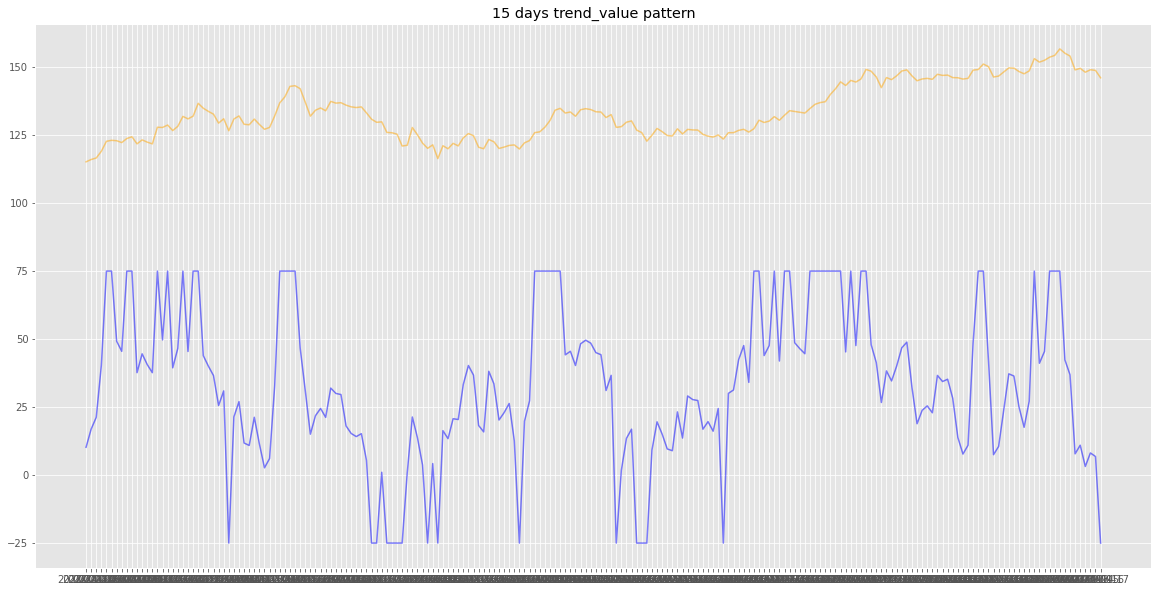

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df.index[-200:],df.close[-200:],color='orange',alpha=.5)
plt.plot(df.index[-200:],df.trend_value[-200:]*50,color='blue',alpha=.5)
plt.title('15 days trend_value pattern')

Text(0.5, 1.0, '10 days trend_value pattern')

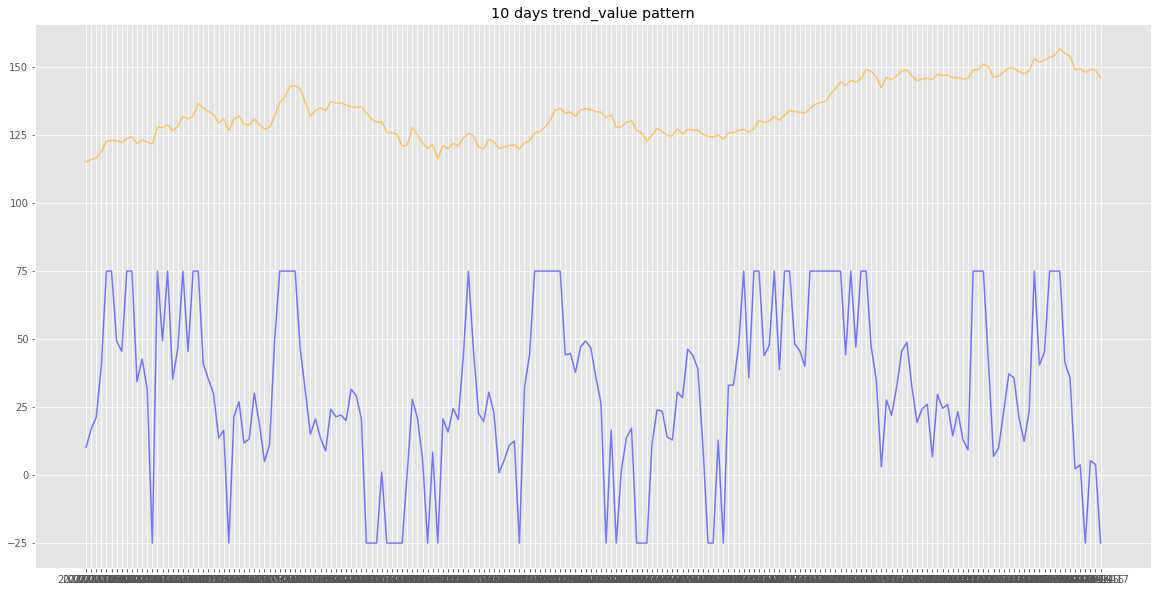

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df.index[-200:],df.close[-200:],color='orange',alpha=.5)
plt.plot(df.index[-200:],df.trend_value[-200:]*50,color='blue',alpha=.5)
plt.title('10 days trend_value pattern')

Text(0.5, 1.0, '10 days trend pattern')

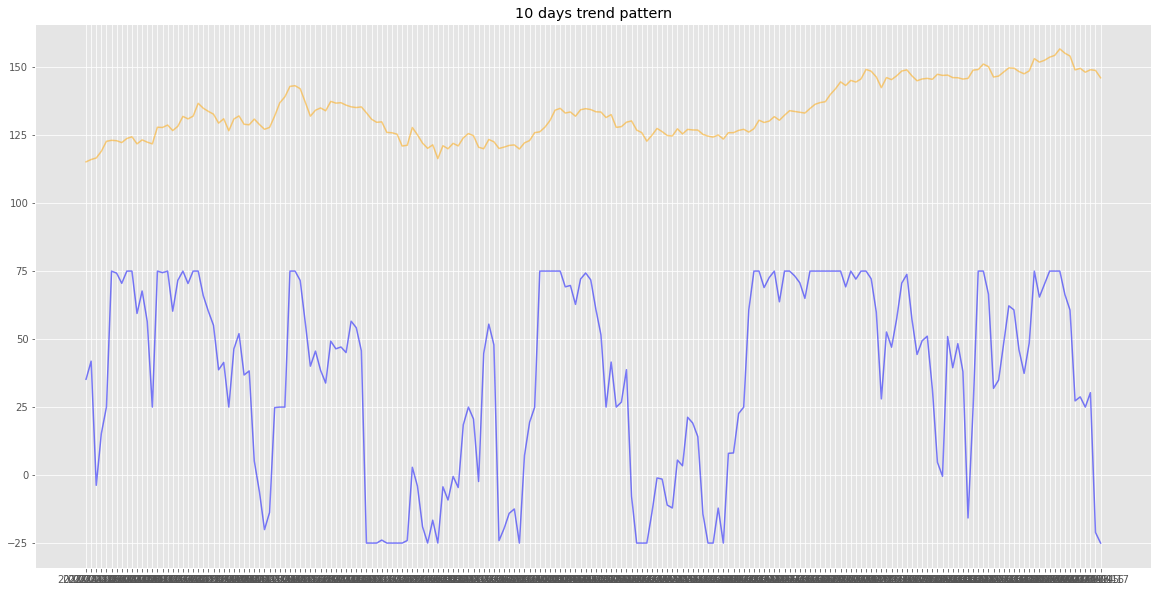

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df.index[-200:],df.close[-200:],color='orange',alpha=.5)
plt.plot(df.index[-200:],df.trend_xvalue[-200:]*50,color='blue',alpha=.5)
plt.title('10 days trend pattern')

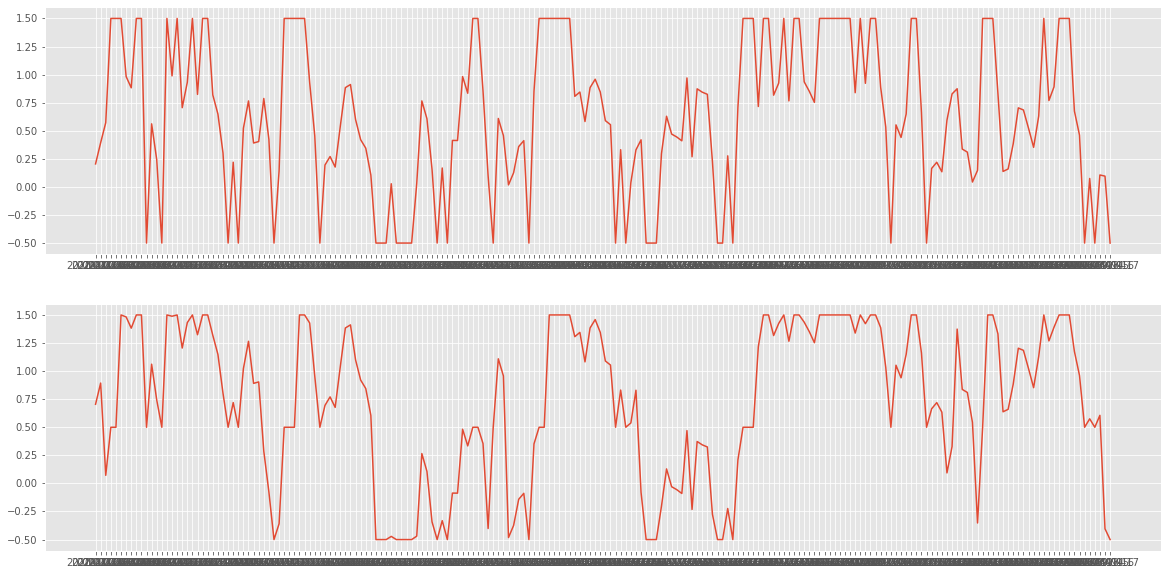

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df.index[-200:],df.trend_value[-200:])
plt.subplot(2, 1, 2)
plt.plot(df.index[-200:],df.trend_xvalue[-200:])
plt.show()

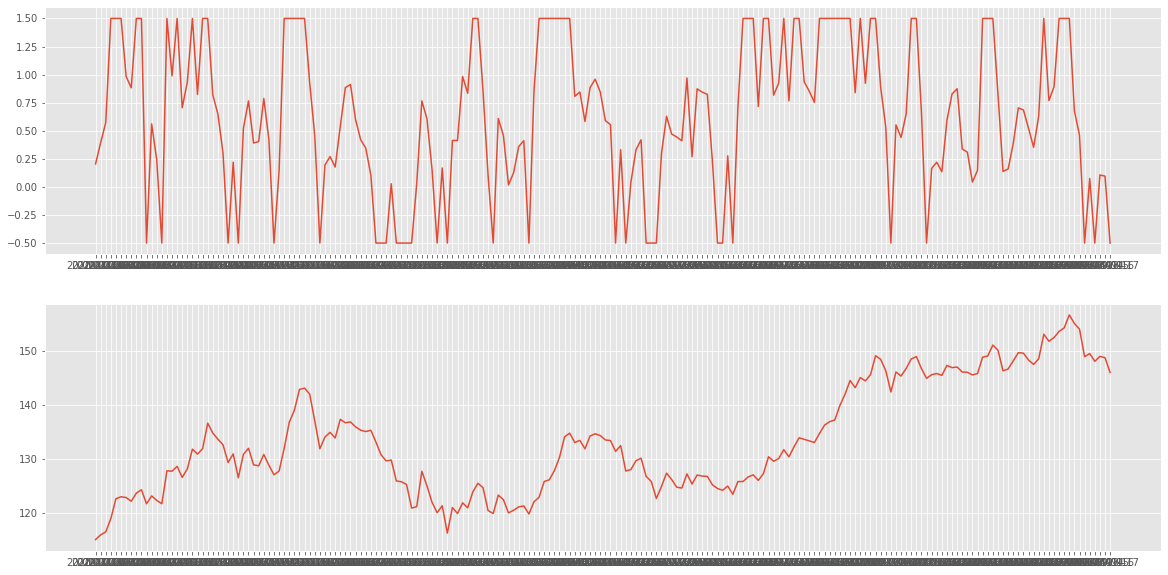

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df.index[-200:],df.trend_value[-200:])
plt.subplot(2, 1, 2)
plt.plot(df.index[-200:],df.close[-200:])
plt.show()

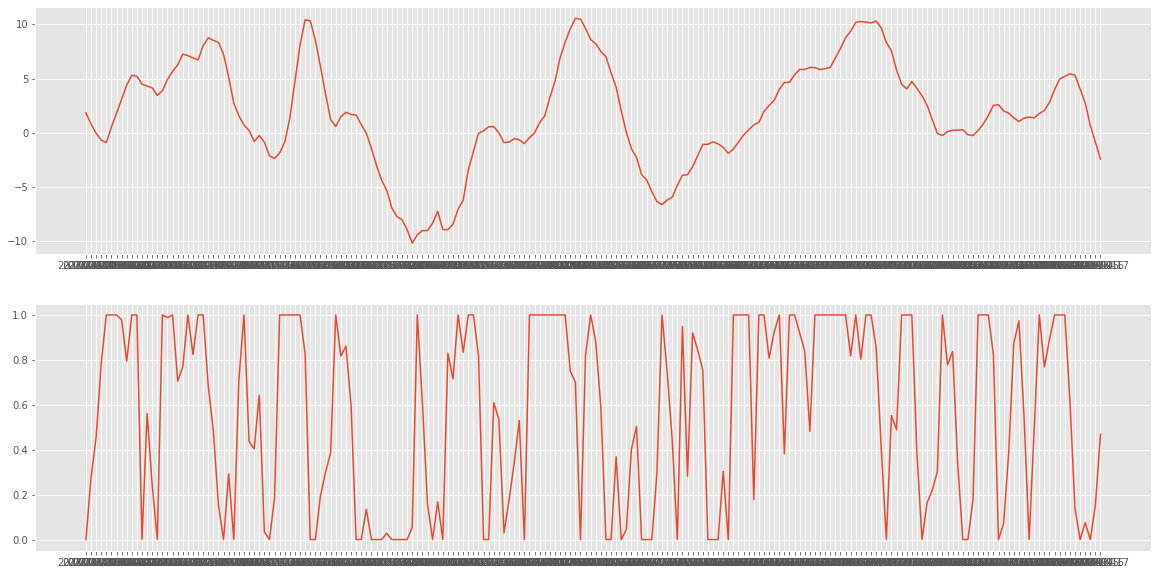

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df.index[-200:],df.smooth_trend[-200:])
plt.subplot(2, 1, 2)
plt.plot(df.index[-200:],df.short_target[-200:])
plt.show()

In [ ]:
df_trend = df
#df_trend.drop(df.tail(3).index, inplace = True)
#df_trend['target'] = signals_3
#df_trend['cum_trend'] = df['target'].cumsum(axis = 0)
df_trend

,open,high,low,close,adj close,volume,1st,2nd,Target,ADX,MACD,MACDSIGNAL,MACDHIST,Momentum,RSI,fastk,fastd,OBV,ATR,NATR,HT_DCPERIOD,sine,leadsine,CORREL,LINEARREG,ADXR,APO,aroondown,aroonup,AROONOSC,BOP,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,TRIX,...,alpha047,alpha049,alpha050,alpha051,alpha052,alpha053,alpha054,alpha055,alpha057,alpha060,alpha061,alpha062,alpha064,alpha065,alpha066,alpha068,alpha071,alpha072,alpha073,alpha074,alpha075,alpha077,alpha078,alpha081,alpha083,alpha084,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101,short_target,smooth_trend,trend_value,trend_xvalue
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2005-12-29,2.635000,2.636429,2.550714,2.551786,2.191005,490025200,2.638214,2.699167,1,31.705994,0.067939,0.088479,-0.020540,-0.020000,53.069789,0.798296,38.804774,3.527109e+10,0.062285,2.440844,26.125547,-0.837609,-0.978551,0.985572,2.624455,38.436581,0.032443,28.571429,21.428571,-7.142857,-0.970822,-56.496135,6.139578,6.090346,52.509764,25.012689,0.218109,28.256997,0.246399,0.635378,...,1.100820,-0.001320,-0.683385,-0.001320,-0.050935,-1.853156,1.100724e+12,-0.458059,-0.045117,0.000025,True,0,0,0,-1.604607,0,16.0,0.943134,-14.0,0,False,0.097364,0.706164,0,-0.033801,1.643966e-01,0.823973,0,0.172881,1.0,-0.329762,True,-7.0,-0.207908,0,-30.153350,NaN,NaN,NaN,NaN
2005-12-30,2.532500,2.586786,2.512143,2.567500,2.204497,624262800,2.667857,2.776309,1,29.628276,0.060487,0.082881,-0.022394,-0.010357,54.629490,32.024737,23.946123,3.589535e+10,0.063168,2.460285,25.119420,-0.931065,-0.916352,0.982771,2.610942,37.843083,0.015870,21.428571,14.285714,-7.142857,0.468899,-82.536321,9.258980,2.617930,45.019523,27.263019,0.241100,25.871981,0.228799,0.627383,...,0.016621,-2.547248,-0.385548,-2.547248,0.120089,1.365986,-6.924341e-01,-0.470216,-6.010371,-0.000586,True,-1,0,0,-1.347661,0,15.0,1.122807,-16.0,0,False,0.096414,0.788355,0,-11.332439,1.000000e+00,0.850362,0,0.144146,3.0,-0.021068,True,-7.0,-0.170862,0,0.462700,NaN,NaN,NaN,NaN
2006-01-03,2.585000,2.669643,2.580357,2.669643,2.292199,807234400,2.686310,2.866786,1,28.494735,0.062107,0.078726,-0.016619,0.130000,63.192585,91.115778,41.312937,3.670259e+10,0.065952,2.470434,24.235858,-0.998593,-0.743610,0.978838,2.625636,37.538667,0.013530,14.285714,7.142857,-7.142857,0.947999,61.323067,26.385170,13.758703,46.899634,24.247041,0.223879,31.983655,0.295313,0.619430,...,-0.245695,-0.102143,-0.302829,-0.102143,0.120562,-3.588158,-8.512101e-01,-0.826815,-6.568440,-0.000509,True,-1,0,0,-2.327476,0,14.0,1.356560,-13.0,0,False,0.096889,0.815995,0,-32.116704,1.000000e+00,0.927335,0,0.118262,6.0,-0.002200,True,-13.0,-0.146165,0,0.937499,NaN,NaN,NaN,NaN
2006-01-04,2.683214,2.713571,2.660714,2.677500,2.298945,619603600,2.699167,2.964881,1,27.956577,0.063295,0.075640,-0.012345,0.128214,63.759199,82.092361,68.410959,3.732219e+10,0.065016,2.428251,23.417971,-0.786213,-0.118977,0.978076,2.637883,36.167588,0.014100,7.142857,100.000000,92.857143,-0.108103,133.448082,27.518399,20.960523,53.865089,22.839016,0.207888,34.952399,0.318147,0.611512,...,0.052098,1.000000,-0.347991,1.000000,0.080099,1.876142,-3.209770e-01,-0.885897,-6.928436,-0.000051,True,0,0,0,-1.308478,0,11.0,0.665628,-2.0,-1,False,0.097839,0.705410,0,-45.829646,1.029461e+00,0.868046,0,0.094277,7.0,-0.004207,True,-13.0,-0.024816,0,-0.106096,NaN,NaN,NaN,NaN
2006-01-05,2.672500,2.675000,2.633929,2.656429,2.280854,449422400,2.776309,3.021191,1,27.007707,0.061824,0.072876,-0.011053,0.081072,61.045157,71.631551,81.613230,3.687277e+10,0.063485,2.389847,22.574241,0.480515,0.959899,0.973749,2.641072,34.669867,0.017349,0.000000,92.857143,92.857143,-0.391298,74.252849,22.090313,14.672403,61.022325,24.733043,0.219823,33.238923,0.295422,0.603269,...,1.281797,1.000000,-0.393630,1.000000,0.076157,-1.130287,6.888031e+12,-0.930165,-0.045259,0.000252,True,0,0,0,-2.319164,0,10.0,0.562864,-1.0,-1,False,0.098076,0.681979,0,-0.273739,9.958330e-01,0.870292,0,0.

In [ ]:
result = df_trend
result = result.dropna()
u = result.select_dtypes(bool)
result[u.columns] = u.astype(int)
result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3569 entries, 2006-02-16 to 2021-09-17
Columns: 150 entries, open to trend_xvalue
dtypes: float64(136), int64(14)
memory usage: 4.1+ MB


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:

result

,open,high,low,close,adj close,volume,1st,2nd,Target,ADX,MACD,MACDSIGNAL,MACDHIST,Momentum,RSI,fastk,fastd,OBV,ATR,NATR,HT_DCPERIOD,sine,leadsine,CORREL,LINEARREG,ADXR,APO,aroondown,aroonup,AROONOSC,BOP,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,TRIX,...,alpha047,alpha049,alpha050,alpha051,alpha052,alpha053,alpha054,alpha055,alpha057,alpha060,alpha061,alpha062,alpha064,alpha065,alpha066,alpha068,alpha071,alpha072,alpha073,alpha074,alpha075,alpha077,alpha078,alpha081,alpha083,alpha084,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101,short_target,smooth_trend,trend_value,trend_xvalue
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-02-16,2.496786,2.536071,2.481429,2.520357,2.164019,948175200,2.508214,2.550000,0,28.563830,-0.071905,-0.062697,-0.009208,-0.054643,47.989526,94.574682,87.834508,3.845012e+10,0.111368,4.418740,20.135337,0.181445,0.823671,0.976924,2.420812,26.348700,-0.183375,71.428571,7.142857,-64.285714,0.431371,10.927757,-4.020948,17.253685,47.207594,25.417556,0.396298,17.937254,0.279669,0.236343,...,-0.269231,-0.048214,-0.908961,-0.048214,0.106782,1.428588,-6.797227e-01,-0.160439,-12.131460,-0.000442,1,-1,-1,0,-1.508430,0,15.5,0.786499,-1.0,0,0,0.088578,0.138591,-1,-63.799335,8.545537e+02,0.937138,0,0.025647,7.0,-0.006911,1,-8.0,0.463904,-1,0.423619,0.517211,-0.314250,0.517211,0.017211
2006-02-17,2.510714,2.531786,2.486071,2.510357,2.155434,575999200,2.525595,2.511190,0,27.755963,-0.064224,-0.063002,-0.001222,-0.055714,47.441129,88.697143,92.439775,3.787412e+10,0.106679,4.249536,19.908045,0.294303,0.883894,0.977258,2.476643,25.284516,-0.179947,64.285714,0.000000,-64.285714,-0.007809,16.857174,-5.117742,17.253685,39.798444,24.639542,0.367991,17.388207,0.259693,0.213889,...,0.257058,2.488846,-0.908961,2.488846,-0.057557,0.068986,1.724077e+11,-0.652402,-0.169079,0.000269,1,0,-1,0,-7.568511,0,12.0,2.029880,-1.0,0,0,0.087153,0.474427,-1,-0.558742,8.192447e-04,0.942072,0,0.038708,7.0,-0.029517,1,-7.0,0.599145,0,-53.070802,0.516666,-0.338661,0.516666,0.016666
2006-02-21,2.521071,2.528571,2.452857,2.467143,2.118330,779606800,2.553929,2.483095,0,27.324452,-0.060922,-0.062586,0.001664,0.063572,45.045553,67.886993,83.719606,3.709452e+10,0.104467,4.234322,19.645726,0.422699,0.939723,0.977471,2.488084,24.431040,-0.168043,57.142857,7.142857,-50.000000,-0.712259,10.289190,-9.908894,21.714809,33.392071,25.634966,0.374920,16.488037,0.241143,0.192462,...,0.690925,0.000396,-0.908961,0.000396,-0.142181,-3.074756,1.116864e+11,-0.691398,-0.190344,0.000161,1,0,-1,0,-6.583947,0,13.0,2.312676,-5.0,0,0,0.086203,0.470124,0,-0.171184,1.004657e+00,0.794401,0,0.052957,7.0,-0.012782,1,-7.0,0.706958,-1,-32.457643,0.404630,-0.345500,0.404630,-0.095370
2006-02-22,2.464286,2.559643,2.428571,2.547143,2.187019,978238800,2.550000,2.466666,0,26.475871,-0.051259,-0.060321,0.009062,0.132857,50.071876,92.886167,83.156768,3.807276e+10,0.106367,4.175939,19.465441,0.625026,0.993930,0.978805,2.525838,23.861841,-0.150018,50.000000,0.000000,-50.000000,0.632149,55.838904,0.143751,15.444326,35.330737,23.378613,0.348140,17.123356,0.254991,0.172932,...,-0.295468,1.000000,-0.908961,1.000000,-0.514681,0.009334,-7.667630e-01,-0.616568,-18.569207,-0.000507,1,0,-1,0,-5.579672,0,10.0,0.841555,-9.0,0,1,0.085965,0.658830,0,-10.432774,1.370469e+00,0.829246,0,0.041558,7.0,-0.006138,1,-7.0,0.718119,0,0.627362,0.612037,-0.350214,0.612037,0.112037
2006-02-23,2.563929,2.607143,2.551071,2.562500,2.200205,856917600,2.511190,2.457500,-1,25.043206,-0.041879,-0.056633,0.014753,0.105000,50.998404,75.000000,78.591054,3.892967e+10,0.103055,4.021667,19.343857,0.806785,0.988274,0.981765,2.570292,23.165479,-0.118972,42.857143,0.000000,-42.857143,-0.025485,127.645755,1.996808,6.418562,41.028879,22.406376,0.323273,19.703526,0.284277,0.155298,...,-0.069168,1.000000,-0.908961,1.000000,-0.499641,4.979832,-2.043962e-01,-0.598690,-24.130128,-0.000034,1,0,-1,0,-4.572786,0,8.0,0.757812,-7.0,0,1,0.086440,0.57

In [ ]:
df_res = result
#df_res = df_res.set_index('timestamp')
df_res = df_res.dropna()
df_res.reset_index(drop=True,inplace=True)
#df_res = df_res.drop('cum_trend',axis=1)
df_res['returns'] = df_res.close.pct_change(periods = 1)
df_res['cum_return'] = df_res.returns.cumsum(axis = 0)
df_res['timestamp'] = result.index
df_res = df_res.dropna()
#df_res = df_res.drop('cum_trend',axis=1)
df_res['sma'] = df_res.iloc[:,1].rolling(window=14).mean()
df_res['ema'] = df_res.iloc[:,0].ewm(span=14,adjust=False).mean()
df_res = df_res.dropna()
df_res

,open,high,low,close,adj close,volume,1st,2nd,Target,ADX,MACD,MACDSIGNAL,MACDHIST,Momentum,RSI,fastk,fastd,OBV,ATR,NATR,HT_DCPERIOD,sine,leadsine,CORREL,LINEARREG,ADXR,APO,aroondown,aroonup,AROONOSC,BOP,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,TRIX,...,alpha053,alpha054,alpha055,alpha057,alpha060,alpha061,alpha062,alpha064,alpha065,alpha066,alpha068,alpha071,alpha072,alpha073,alpha074,alpha075,alpha077,alpha078,alpha081,alpha083,alpha084,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101,short_target,smooth_trend,trend_value,trend_xvalue,returns,cum_return,timestamp,sma,ema
14,2.356429,2.373929,2.278929,2.283214,1.960405,799304800,2.335595,2.323810,0,27.122841,-0.061751,-0.048235,-0.013516,-0.279286,35.576191,1.966887,14.450861,3.549579e+10,0.090023,3.942822,18.645541,-0.974027,-0.528629,0.915226,2.298720,27.439402,-0.011071,100.000000,28.571429,-71.428571,-0.770684,-147.330689,-28.847617,41.815083,30.178029,30.509460,0.384518,12.517642,0.157763,0.014108,...,-0.018165,1.101900e+11,0.282662,-0.200223,-0.000018,1,0,0,0,-6.442175,0,7.0,0.789776,-11.0,-1,0,0.083116,0.369691,-1,-0.068863,1.824954e-03,0.993728,0,0.087390,7.0,-0.003690,1,-8.0,-0.101282,-1,-24.260045,0.000000,-0.093268,-0.500000,-0.500000,-0.026348,-0.095978,2006-03-09,2.503699,2.448729
15,2.287500,2.303214,2.230357,2.256786,1.937713,1043142800,2.371786,2.297143,0,28.537912,-0.069319,-0.052452,-0.016867,-0.295357,34.208441,14.041995,10.088720,3.445264e+10,0.088797,3.934663,18.527181,-0.857843,-0.243196,0.920949,2.266526,27.931182,-0.018468,100.000000,21.428571,-78.571429,-0.421566,-149.277776,-31.583117,46.933839,29.202628,32.628559,0.405624,11.784027,0.146494,-0.001015,...,-0.011964,2.097182e+11,-0.527899,-0.231817,0.000086,1,0,0,-1,-5.435763,0,8.0,0.900000,-15.0,0,0,0.081928,0.432197,0,-0.114717,9.909945e-01,0.998976,0,0.106863,7.0,-0.105714,1,-8.0,0.038946,-1,-30.638695,0.000000,-0.113447,-0.500000,-0.500000,-0.011575,-0.107553,2006-03-10,2.487372,2.427232
16,2.323214,2.367143,2.313929,2.345714,2.014069,861187600,2.355476,2.267381,0,28.688292,-0.067364,-0.055434,-0.011930,-0.189643,42.253542,67.999859,28.002913,3.531383e+10,0.090337,3.851148,18.304322,-0.524970,0.230623,0.919629,2.277805,27.582081,-0.027715,92.857143,14.285714,-78.571429,0.422821,-70.433487,-15.492915,30.643224,36.218426,29.781447,0.376651,15.810580,0.199959,-0.015527,...,1.738130,-5.692029e-01,-0.354164,-33.176802,-0.000654,1,-1,0,0,-4.443600,0,7.0,0.921439,-9.0,-1,0,0.080978,0.561423,-1,-34.845659,2.576997e+02,0.983021,0,0.084540,7.0,-0.020408,1,-7.0,0.245904,-1,0.415022,0.290886,-0.131893,0.290886,-0.209114,0.039405,-0.068148,2006-03-13,2.475842,2.413363
17,2.348929,2.404286,2.339286,2.404286,2.064359,642020400,2.323810,2.231786,-1,28.222575,-0.060393,-0.056426,-0.003967,-0.041785,46.862460,100.000000,60.680618,3.595585e+10,0.088527,3.682056,18.126799,-0.257797,0.500916,0.931887,2.301805,26.632891,-0.033814,85.714286,7.142857,-78.571429,0.851646,-32.728308,-6.275080,22.168261,34.066194,28.219542,0.349747,17.978287,0.222819,-0.028752,...,-0.361126,-8.900590e-01,0.066040,-74.174149,-0.000846,1,-1,0,0,-3.458323,0,7.0,1.243743,-4.0,-1,0,0.080503,0.660575,-1,-25.127710,1.109891e+00,0.990871,0,0.061981,6.0,-0.235476,1,-8.0,0.398361,0,0.838742,0.482477,-0.141839,0.482477,-0.017523,0.024970,-0.043179,2006-03-14,2.464745,2.404772
18,2.418214,2.430000,2.340000,2.365357,2.030933,891996000,2.297143,2.186190,-1,27.387550,-0.057348,-0.056610,-0.000738,-0.102500,44.330019,67.620703,78.540187,3.506386e+10,0.088632,3.747102,18.146091,-0.007278,0.701941,0.921929,2.318994,25.598176,-0.046511,78.571429,0.000000,-78.571429,-0.587300,-28.132894,-11.339962,16.532219,26.121917,26.172757,0.324765,18.746592,0.232618,-0.041174,...,-1.443102,4.242162e+11,0.170978,-0.084268,-0.000119,1,0,0,0,-2.455474,0,6.0,2.407524,-2.0,0,0,0.079791,0.710293,-1,-0.139593,9.888185e-01,0.926578,0,0.097127,3.0,-0.002553,1,-4.0,0.400617,0,-26.333281,0.355139,-0.135822,0.355139,-0.144861,-0.016192,

# Fluctuation Percentage

In [ ]:
def fluc_per(df,headers):
    for col in headers:
        temp_header = col +'_fp'
        df[temp_header] = df[col].pct_change()
    return df

In [ ]:
col_list = ['sma', 'ema','slowk', 'slowd','fastk','fastd','close','1st', '2nd','CCI','adj close']
df_fluc = fluc_per(df_res,col_list)
df_fluc = df_fluc.reset_index(drop=True)
df_fluc

,open,high,low,close,adj close,volume,1st,2nd,Target,ADX,MACD,MACDSIGNAL,MACDHIST,Momentum,RSI,fastk,fastd,OBV,ATR,NATR,HT_DCPERIOD,sine,leadsine,CORREL,LINEARREG,ADXR,APO,aroondown,aroonup,AROONOSC,BOP,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,TRIX,...,alpha071,alpha072,alpha073,alpha074,alpha075,alpha077,alpha078,alpha081,alpha083,alpha084,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101,short_target,smooth_trend,trend_value,trend_xvalue,returns,cum_return,timestamp,sma,ema,sma_fp,ema_fp,slowk_fp,slowd_fp,fastk_fp,fastd_fp,close_fp,1st_fp,2nd_fp,CCI_fp,adj close_fp
0,2.356429,2.373929,2.278929,2.283214,1.960405,799304800,2.335595,2.323810,0,27.122841,-0.061751,-0.048235,-0.013516,-0.279286,35.576191,1.966887,14.450861,3.549579e+10,0.090023,3.942822,18.645541,-0.974027,-0.528629,0.915226,2.298720,27.439402,-0.011071,100.000000,28.571429,-71.428571,-0.770684,-147.330689,-28.847617,41.815083,30.178029,30.509460,0.384518,12.517642,0.157763,0.014108,...,7.0,0.789776,-11.0,-1,0,0.083116,0.369691,-1,-0.068863,1.824954e-03,0.993728,0,0.087390,7.0,-0.003690,1,-8.0,-0.101282,-1,-24.260045,0.000000,-0.093268,-0.500000,-0.500000,-0.026348,-0.095978,2006-03-09,2.503699,2.448729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.287500,2.303214,2.230357,2.256786,1.937713,1043142800,2.371786,2.297143,0,28.537912,-0.069319,-0.052452,-0.016867,-0.295357,34.208441,14.041995,10.088720,3.445264e+10,0.088797,3.934663,18.527181,-0.857843,-0.243196,0.920949,2.266526,27.931182,-0.018468,100.000000,21.428571,-78.571429,-0.421566,-149.277776,-31.583117,46.933839,29.202628,32.628559,0.405624,11.784027,0.146494,-0.001015,...,8.0,0.900000,-15.0,0,0,0.081928,0.432197,0,-0.114717,9.909945e-01,0.998976,0,0.106863,7.0,-0.105714,1,-8.0,0.038946,-1,-30.638695,0.000000,-0.113447,-0.500000,-0.500000,-0.011575,-0.107553,2006-03-10,2.487372,2.427232,-0.006521,-0.008779,-0.301860,-0.061436,6.139199,-0.301860,-0.011575,0.015495,-0.011475,0.013216,-0.011575
2,2.323214,2.367143,2.313929,2.345714,2.014069,861187600,2.355476,2.267381,0,28.688292,-0.067364,-0.055434,-0.011930,-0.189643,42.253542,67.999859,28.002913,3.531383e+10,0.090337,3.851148,18.304322,-0.524970,0.230623,0.919629,2.277805,27.582081,-0.027715,92.857143,14.285714,-78.571429,0.422821,-70.433487,-15.492915,30.643224,36.218426,29.781447,0.376651,15.810580,0.199959,-0.015527,...,7.0,0.921439,-9.0,-1,0,0.080978,0.561423,-1,-34.845659,2.576997e+02,0.983021,0,0.084540,7.0,-0.020408,1,-7.0,0.245904,-1,0.415022,0.290886,-0.131893,0.290886,-0.209114,0.039405,-0.068148,2006-03-13,2.475842,2.413363,-0.004636,-0.005714,1.775666,0.289462,3.842607,1.775666,0.039405,-0.006876,-0.012956,-0.528172,0.039405
3,2.348929,2.404286,2.339286,2.404286,2.064359,642020400,2.323810,2.231786,-1,28.222575,-0.060393,-0.056426,-0.003967,-0.041785,46.862460,100.000000,60.680618,3.595585e+10,0.088527,3.682056,18.126799,-0.257797,0.500916,0.931887,2.301805,26.632891,-0.033814,85.714286,7.142857,-78.571429,0.851646,-32.728308,-6.275080,22.168261,34.066194,28.219542,0.349747,17.978287,0.222819,-0.028752,...,7.0,1.243743,-4.0,-1,0,0.080503,0.660575,-1,-25.127710,1.109891e+00,0.990871,0,0.061981,6.0,-0.235476,1,-8.0,0.398361,0,0.838742,0.482477,-0.141839,0.482477,-0.017523,0.024970,-0.043179,2006-03-14,2.464745,2.404772,-0.004482,-0.003560,1.166939,0.879855,0.470591,1.166939,0.024970,-0.013444,-0.015699,-0.535330,0.024969
4,2.418214,2.430000,2.340000,2.365357,2.030933,891996000,2.297143,2.186190,-1,27.387550,-0.057348,-0.056610,-0.000738,-0.102500,44.330019,67.620703,78.540187,3.506386e+10,0.088632,3.747102,18.146091,-0.007278,0.701941,0.921929,2.318994,25.598176,-0.046511,78.571429,0.000000,-78.571429,-0.587300,-28.132894,-11.339962,16.532219,26.121917,26.172757,0.324765,18.746592,0.232618,-0.041174,...,6.0,2.407524,-2.0,0,0,0.079791,0.710293,-1,-0.139593,9.888185e-01,0.926578,0,0.097127,3.0,-0.002553,1,-4.0,0.400617,0,-26.333281,0.355139,-0.135822,0.355139,-0.144861,-0.016192,-0.059370,2006-03-1

# Polarizing Dataset

## ***Important Remainder: Later Try to Identify and Build some FUZZY Logic based rules for Polarizing few features to represent importance of respective features***


In [ ]:
ADX_pol1 = []
ADX_pol2 = []
ADX_pol3 = []
ADX_pol4 = []

for i in range(len(df_fluc)):
    if(0 <= df_fluc['ADX'].loc[i] <= 25):
        ADX_pol1.append(1)    #Weak Strength of trend
    else:
        ADX_pol1.append(0)
            
for i in range(len(df_fluc)):
    if(25 < df_fluc['ADX'].loc[i] <= 50):
        ADX_pol2.append(1)    #Weak Strength of trend
    else:
        ADX_pol2.append(0)  #Strong Strength of trend
        
for i in range(len(df_fluc)):
    if(50 < df_fluc['ADX'].loc[i] <= 70):
        ADX_pol3.append(1)    #Weak Strength of trend
    else:
        ADX_pol3.append(1)     #Very strong trend
for i in range(len(df_fluc)):
    if(70 <= df_fluc['ADX'].loc[i] <= 100):
        ADX_pol4.append(1)    #Weak Strength of trend
    else:
        ADX_pol4.append(0) #Extremely Strong tend
        
df_fluc['ADX_pol_weak'] = ADX_pol1
df_fluc['ADX_pol_strong'] = ADX_pol2
df_fluc['ADX_pol_verystrong'] = ADX_pol3
df_fluc['ADX_pol_extreme'] = ADX_pol4

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_##_#_#_#_#_#_#_#_#_#_#_#################_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_

df_fluc['uptrend'] = 0
df_fluc['downtrend'] = 0
for i in range(len(df_fluc)):
  if(df_fluc['PLUS_DI'].loc[i]>df_fluc['MINUS_DI'][i]):
    df_fluc.at[df_fluc.index[i], 'uptrend'] = 1
  elif(df_fluc['PLUS_DI'].loc[i]<df_fluc['MINUS_DI'][i]):
    df_fluc.at[df_fluc.index[i], 'downtrend'] = -1

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
####NOTE: Later Try to Implement and Build some FUZZY Logic based rules for Polarizing few features to view clear importance of respective features_#-#-#-#-#-#-#  
df_fluc['ADXR_pol'] = 0
for i in range(len(df_fluc)):
  if(df_fluc['ADXR'].loc[i]>=25):
    df_fluc.at[df_fluc.index[i], 'ADXR_pol'] = 1

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#__#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
df_fluc['aroonup_pol'] = 0
for i in range(len(df_fluc)):
  if(df_fluc['aroonup'].loc[i]>25):
    df_fluc.at[df_fluc.index[i], 'aroonup_pol'] = 1

df_fluc['aroondown_pol'] = 0
for i in range(len(df_fluc)):
  if(df_fluc['aroondown'].loc[i]>25):
    df_fluc.at[df_fluc.index[i], 'aroondown_pol'] = 1

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#__#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
df_fluc['AD_pol'] = 0
for i in range(len(df_fluc)):
  if(df_fluc['AD'].loc[i]>0):
    df_fluc.at[df_fluc.index[i], 'AD_pol'] = 1
  else:
    df_fluc.at[df_fluc.index[i], 'AD_pol'] = -1


df_fluc['ADOSC_pol'] = 0
for i in range(len(df_fluc)):
  if(df_fluc['ADOSC'].loc[i]>25):
    df_fluc.at[df_fluc.index[i], 'ADOSC_pol'] = 1
  else:
    df_fluc.at[df_fluc.index[i], 'ADOSC_pol'] = -1

#_#_#_##_#_#_#_#_##_#_#_#_#_#_##_#_#_#_#_##_#_#_##_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_

df_fluc['willr_pol'] = 0
for i in range(len(df_fluc)):
  if(0<=df_fluc['WILLR'].loc[i]<=20):
    df_fluc.at[df_fluc.index[i], 'willr_pol'] = 0     #Overbougth
  else:
    df_fluc.at[df_fluc.index[i], 'willr_pol'] = 1     #oversold 

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_##_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#
MOMENTUM_pol = []
for i in range(len(df_fluc)):
    if(df_fluc['Momentum'].loc[i]>0):
        MOMENTUM_pol.append(1)
    elif(df_fluc['Momentum'].loc[i]<0):
        MOMENTUM_pol.append(-1)
    else:
        MOMENTUM_pol.append(0)

df_fluc['Momentum_pol'] = MOMENTUM_pol    

#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#__#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_##_#_#_#_#_#__#_#_#_#_#_#_#_##_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_
RSI_pol = []
for i in range(len(df_fluc)):
    if(df_fluc['RSI'].loc[i]>=70):
        RSI_pol.append(-1)   ##OVERBOUGHT
    elif(df_fluc['RSI'].loc[i]<=30):
        RSI_pol.append(1)    ##OVERSOLD
    else:
        RSI_pol.append(0)
df_fluc['RSI_pol'] = RSI_pol
#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#_#
'''
ROC_pol = []
for i in range(len(df_fluc)):
    if(df['ROC'].loc[i]>0):
        ROC_pol.append(-1)   ##OVERBOUGHT
    elif(df['ROC'].loc[i]<0):
        ROC_pol.append(-1)    ##OVERSOLD
    else:
        ROC_pol.append(0)
df_fluc['ROC_pol'] = ROC_pol
 '''

"\nROC_pol = []\nfor i in range(len(df_fluc)):\n    if(df['ROC'].loc[i]>0):\n        ROC_pol.append(-1)   ##OVERBOUGHT\n    elif(df['ROC'].loc[i]<0):\n        ROC_pol.append(-1)    ##OVERSOLD\n    else:\n        ROC_pol.append(0)\ndf_fluc['ROC_pol'] = ROC_pol\n "

In [ ]:
df_for_model = df_fluc
df_for_model=df_for_model.set_index('timestamp')
df_for_model = df_for_model.dropna()
df_for_model

,open,high,low,close,adj close,volume,1st,2nd,Target,ADX,MACD,MACDSIGNAL,MACDHIST,Momentum,RSI,fastk,fastd,OBV,ATR,NATR,HT_DCPERIOD,sine,leadsine,CORREL,LINEARREG,ADXR,APO,aroondown,aroonup,AROONOSC,BOP,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,TRIX,...,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,alpha101,short_target,smooth_trend,trend_value,trend_xvalue,returns,cum_return,sma,ema,sma_fp,ema_fp,slowk_fp,slowd_fp,fastk_fp,fastd_fp,close_fp,1st_fp,2nd_fp,CCI_fp,adj close_fp,ADX_pol_weak,ADX_pol_strong,ADX_pol_verystrong,ADX_pol_extreme,uptrend,downtrend,ADXR_pol,aroonup_pol,aroondown_pol,AD_pol,ADOSC_pol,willr_pol,Momentum_pol,RSI_pol
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-03-10,2.287500,2.303214,2.230357,2.256786,1.937713,1043142800,2.371786,2.297143,0,28.537912,-0.069319,-0.052452,-0.016867,-0.295357,34.208441,14.041995,10.088720,3.445264e+10,0.088797,3.934663,18.527181,-0.857843,-0.243196,0.920949,2.266526,27.931182,-0.018468,100.000000,21.428571,-78.571429,-0.421566,-149.277776,-31.583117,46.933839,29.202628,32.628559,0.405624,11.784027,0.146494,-0.001015,...,7.0,-0.105714,1,-8.0,0.038946,-1,-30.638695,0.000000,-0.113447,-0.500000,-0.500000,-0.011575,-0.107553,2.487372,2.427232,-0.006521,-0.008779,-0.301860,-0.061436,6.139199,-0.301860,-0.011575,0.015495,-0.011475,0.013216,-0.011575,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-13,2.323214,2.367143,2.313929,2.345714,2.014069,861187600,2.355476,2.267381,0,28.688292,-0.067364,-0.055434,-0.011930,-0.189643,42.253542,67.999859,28.002913,3.531383e+10,0.090337,3.851148,18.304322,-0.524970,0.230623,0.919629,2.277805,27.582081,-0.027715,92.857143,14.285714,-78.571429,0.422821,-70.433487,-15.492915,30.643224,36.218426,29.781447,0.376651,15.810580,0.199959,-0.015527,...,7.0,-0.020408,1,-7.0,0.245904,-1,0.415022,0.290886,-0.131893,0.290886,-0.209114,0.039405,-0.068148,2.475842,2.413363,-0.004636,-0.005714,1.775666,0.289462,3.842607,1.775666,0.039405,-0.006876,-0.012956,-0.528172,0.039405,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-14,2.348929,2.404286,2.339286,2.404286,2.064359,642020400,2.323810,2.231786,-1,28.222575,-0.060393,-0.056426,-0.003967,-0.041785,46.862460,100.000000,60.680618,3.595585e+10,0.088527,3.682056,18.126799,-0.257797,0.500916,0.931887,2.301805,26.632891,-0.033814,85.714286,7.142857,-78.571429,0.851646,-32.728308,-6.275080,22.168261,34.066194,28.219542,0.349747,17.978287,0.222819,-0.028752,...,6.0,-0.235476,1,-8.0,0.398361,0,0.838742,0.482477,-0.141839,0.482477,-0.017523,0.024970,-0.043179,2.464745,2.404772,-0.004482,-0.003560,1.166939,0.879855,0.470591,1.166939,0.024970,-0.013444,-0.015699,-0.535330,0.024969,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-15,2.418214,2.430000,2.340000,2.365357,2.030933,891996000,2.297143,2.186190,-1,27.387550,-0.057348,-0.056610,-0.000738,-0.102500,44.330019,67.620703,78.540187,3.506386e+10,0.088632,3.747102,18.146091,-0.007278,0.701941,0.921929,2.318994,25.598176,-0.046511,78.571429,0.000000,-78.571429,-0.587300,-28.132894,-11.339962,16.532219,26.121917,26.172757,0.324765,18.746592,0.232618,-0.041174,...,3.0,-0.002553,1,-4.0,0.400617,0,-26.333281,0.355139,-0.135822,0.355139,-0.144861,-0.016192,-0.059370,2.452092,2.406564,-0.005134,0.000745,0.294321,0.693023,-0.323793,0.294321,-0.016192,-0.011475,-0.020430,-0.140411,-0.016192,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-16,2.387500,2.389286,2.296429,2.296786,1.972059,749638400,2.267381,2.164167,-1,27.075100,-0.059779,-0.057244,-0.002535,-0.189285,40.208269,33.273894,66.964866,3.431422e+10,0.088934,3.872111,18.315230,0.191196,0.829258,0.905491,2.321727,24.986246,-0.054432,71.428571,0.000000,-71.428571,-0.976922,-67.734596,-19.583462,23.013254,25.771481,27.720273,0.345139,17.348485,0.216002,-0.053505,...,1.0,-0.023438,1,-8.0,0.272738,0,-25.203543,0.135429,-0.135536,0.135429,-0.364571,-0.028990,-0.088360,2.436811,2.404022,-0.006232,-0.001056,-0.147381,0.232993,-0.507933,-0.147381,-0.028990,-0.012956,-0.010074,1.407665,-0.028989,0,1,1,0,0

# Min-Max Scaling

In [ ]:
def scaling(df,headers):
    df = df.dropna()
    df_scaled = df[headers]
    sc = MinMaxScaler()
    scaled_df = sc.fit_transform(df_scaled)
    scaled_df = pd.DataFrame(data = scaled_df,columns=headers,index = df.index)
    return scaled_df

In [ ]:
#Final checking if dataset contains 'infinity' or 'nan' points and drop of them before RFE
count = np.isinf(df_for_model).values.sum()
print("It contains " + str(count) + " infinite values")

print("printing column name where infinity is present")
col_name = df_for_model.columns.to_series()[np.isinf(df_for_model).any()]
print(col_name)
# printing row index with infinity
print()
print("printing row index with infinity ")
  
r = df_for_model.index[np.isinf(df_for_model).any(1)]
print(r)

df_for_model.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
df_for_model = df_for_model.dropna()

It contains 7 infinite values
printing column name where infinity is present
fastk_fp    fastk_fp
dtype: object

printing row index with infinity 
Index(['2006-05-31', '2009-01-21', '2012-05-18', '2013-06-20', '2015-03-26',
       '2016-09-12', '2018-03-26'],
      dtype='object', name='timestamp')


In [ ]:
col_list = ['close', 'volume','open','AD','ADOSC','COSH', 'high','alpha046','alpha057','adj close', 'fastk','fastd','low','MACD','CCI_fp','RSI', 'MACDSIGNAL', 'MACDHIST', 'NATR','LINEARREG','OBV', 'ATR','alpha004','alpha007','alpha009','alpha010','alpha012','alpha019','alpha022','alpha023','alpha024','alpha029','alpha031','alpha035','alpha036','alpha041','alpha042','alpha043','alpha044','alpha047','alpha049','alpha051','alpha052','alpha053','alpha054','alpha066','alpha071','alpha072','alpha073','alpha083','alpha084','alpha101','1st','2nd','ADX','ADXR','APO','HT_DCPERIOD','aroonup','aroondown','AROONOSC','TAN','CCI','CMO','DX','MFI','MINUS_DI','MINUS_DM','PLUS_DI','PLUS_DM','ULTOSC','WILLR','WCLPRICE','slowk','slowd','HT_DCPHASE','CEIL','fastk_fp','EXP','CCI_fp','SINH','sma','ema']
#'DPV', 'PDPV'
min_maxscale = scaling(df_for_model,col_list)
min_maxscale

,close,volume,open,AD,ADOSC,COSH,high,alpha046,alpha057,adj close,fastk,fastd,low,MACD,CCI_fp,RSI,MACDSIGNAL,MACDHIST,NATR,LINEARREG,OBV,ATR,alpha004,alpha007,alpha009,alpha010,alpha012,alpha019,alpha022,alpha023,alpha024,alpha029,alpha031,alpha035,alpha036,alpha041,alpha042,alpha043,alpha044,alpha047,...,alpha053,alpha054,alpha066,alpha071,alpha072,alpha073,alpha083,alpha084,alpha101,1st,2nd,ADX,ADXR,APO,HT_DCPERIOD,aroonup,aroondown,AROONOSC,TAN,CCI,CMO,DX,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,ULTOSC,WILLR,WCLPRICE,slowk,slowd,HT_DCPHASE,CEIL,fastk_fp,EXP,CCI_fp,SINH,sma,ema
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-03-10,0.002496,0.299831,0.002836,0.125807,0.221581,2.687208e-68,0.002616,0.491604,0.999944,0.002139,0.140420,0.094720,0.002529,0.374820,0.715546,0.190026,0.355068,0.514924,0.290467,0.002819,0.260341,0.006570,1.000,0.875000,0.493250,0.493250,0.506768,0.933977,0.540119,0.669869,0.503697,0.280424,0.902942,0.065054,0.622866,0.002572,4.062160e-04,0.672956,0.762144,0.141347,...,0.499960,2.671486e-12,0.366444,0.466667,0.000426,0.1250,0.999902,1.368667e-195,0.866866,0.003407,0.002921,0.334822,0.318959,0.418106,0.157606,0.214286,1.000000,0.107143,0.520320,0.268139,0.190026,0.549656,0.268309,0.531855,0.016089,0.108059,0.002151,0.134409,0.070143,0.002534,0.094720,0.096160,0.961483,0.006452,0.006798,2.731260e-68,0.715546,2.775312e-68,0.003071,0.002973
2006-03-13,0.003070,0.245149,0.003067,0.128181,0.245415,3.471760e-68,0.003027,0.485073,0.991760,0.002632,0.679999,0.277976,0.003076,0.375031,0.715284,0.305988,0.354705,0.516458,0.282445,0.002892,0.276275,0.006921,0.750,0.741667,0.485733,0.485733,0.514267,0.940163,0.542011,0.669869,0.488705,0.693918,0.732688,0.272849,0.652743,0.003052,2.316757e-04,0.496855,0.906147,0.048744,...,0.500085,5.399749e-24,0.508230,0.400000,0.000436,0.5000,0.970152,3.559104e-193,0.997556,0.003301,0.002727,0.337251,0.312515,0.417478,0.150833,0.142857,0.928571,0.107143,0.520378,0.379495,0.305988,0.358841,0.346487,0.479145,0.014780,0.180415,0.004450,0.225237,0.306161,0.003061,0.277976,0.138866,0.035974,0.006452,0.004611,3.523758e-68,0.715284,3.575757e-68,0.002995,0.002881
2006-03-14,0.003449,0.179284,0.003232,0.137275,0.322706,4.028721e-68,0.003267,0.488147,0.981575,0.002956,1.000000,0.612256,0.003243,0.375784,0.715280,0.372421,0.354584,0.518932,0.266201,0.003047,0.288154,0.006509,0.250,0.491667,0.493051,0.493051,0.506949,0.055040,0.511555,0.669869,0.488517,0.671411,0.685966,0.096102,0.697025,0.003255,2.294834e-04,0.037736,0.975358,0.025005,...,0.499936,1.312537e-24,0.649031,0.400000,0.000588,0.8125,0.978476,1.532875e-195,0.999339,0.003095,0.002495,0.329729,0.294996,0.417064,0.145438,0.071429,0.857143,0.107143,0.520411,0.432749,0.372421,0.259572,0.322505,0.450229,0.013564,0.219367,0.005433,0.326260,0.461612,0.003352,0.612256,0.306252,0.082520,0.006452,0.001400,4.085580e-68,0.715280,4.142439e-68,0.002922,0.002824
2006-03-15,0.003197,0.254408,0.003679,0.131760,0.335516,3.654858e-68,0.003432,0.491604,0.999981,0.002741,0.676207,0.794952,0.003247,0.376113,0.715471,0.335918,0.354561,0.519936,0.272450,0.003158,0.271650,0.006533,0.125,0.650000,0.500946,0.500946,0.514465,0.934293,0.511984,0.669869,0.496170,0.051170,0.830386,0.043548,0.594472,0.003339,4.675196e-04,0.559748,0.778429,0.144942,...,0.499859,5.403860e-12,0.792344,0.333333,0.001139,0.9375,0.999880,1.365662e-195,0.884985,0.002921,0.002198,0.316241,0.275899,0.416202,0.146024,0.000000,0.785714,0.107143,0.520389,0.439239,0.335918,0.193556,0.233980,0.412336,0.012435,0.233174,0.005854,0.347034,0.362069,0.003269,0.794952,0.554097,0.122932,0.006452,0.000644,3.708518e-68,0.715471,3.762179e-68,0.002838,0.002836
2006-03-16,0.002754,0.211626,0.003481,0.121223,0.293519,3.031307e-68,0.003170,0.491604,0.999987,0.002361,0.332739,0.676541,0.002962,0.375850,0.716221,0.276508,0.354484,0.519377,0.284458,0.003176,0.257780,0.006602,0.750,0.491667,0.493241,0.493241,0.506759,0.920217,0.518767,0.669869,0.503633,0.464664,0.883

# Gathering all processed,scaled and transformed data in single dataframe

In [ ]:
li = []
for col in df_for_model.columns:
    if col in min_maxscale.columns:
        print('do nothing',end=' ')
    else:
        li.append(col)
    i = i + 1

df_fluc_actual = df_for_model[li]
#df_fluc_actual = df_fluc_actual.set_index('timestamp')
df_fluc_actual = df_fluc_actual.dropna()
final_df = pd.concat([min_maxscale, df_fluc_actual], axis=1)
final_df = final_df.dropna()
final_df

do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing do nothing 

,close,volume,open,AD,ADOSC,COSH,high,alpha046,alpha057,adj close,fastk,fastd,low,MACD,CCI_fp,RSI,MACDSIGNAL,MACDHIST,NATR,LINEARREG,OBV,ATR,alpha004,alpha007,alpha009,alpha010,alpha012,alpha019,alpha022,alpha023,alpha024,alpha029,alpha031,alpha035,alpha036,alpha041,alpha042,alpha043,alpha044,alpha047,...,alpha078,alpha081,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,short_target,smooth_trend,trend_value,trend_xvalue,returns,cum_return,sma_fp,ema_fp,slowk_fp,slowd_fp,fastd_fp,close_fp,1st_fp,2nd_fp,adj close_fp,ADX_pol_weak,ADX_pol_strong,ADX_pol_verystrong,ADX_pol_extreme,uptrend,downtrend,ADXR_pol,aroonup_pol,aroondown_pol,AD_pol,ADOSC_pol,willr_pol,Momentum_pol,RSI_pol
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-03-10,0.002496,0.299831,0.002836,0.125807,0.221581,2.687208e-68,0.002616,0.491604,0.999944,0.002139,0.140420,0.094720,0.002529,0.374820,0.715546,0.190026,0.355068,0.514924,0.290467,0.002819,0.260341,0.006570,1.000,0.875000,0.493250,0.493250,0.506768,0.933977,0.540119,0.669869,0.503697,0.280424,0.902942,0.065054,0.622866,0.002572,4.062160e-04,0.672956,0.762144,0.141347,...,0.432197,0,0.998976,0,0.106863,7.0,-0.105714,1,-8.0,0.038946,-1,0.000000,-0.113447,-0.500000,-0.500000,-0.011575,-0.107553,-0.006521,-0.008779,-0.301860,-0.061436,-0.301860,-0.011575,0.015495,-0.011475,-0.011575,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-13,0.003070,0.245149,0.003067,0.128181,0.245415,3.471760e-68,0.003027,0.485073,0.991760,0.002632,0.679999,0.277976,0.003076,0.375031,0.715284,0.305988,0.354705,0.516458,0.282445,0.002892,0.276275,0.006921,0.750,0.741667,0.485733,0.485733,0.514267,0.940163,0.542011,0.669869,0.488705,0.693918,0.732688,0.272849,0.652743,0.003052,2.316757e-04,0.496855,0.906147,0.048744,...,0.561423,-1,0.983021,0,0.084540,7.0,-0.020408,1,-7.0,0.245904,-1,0.290886,-0.131893,0.290886,-0.209114,0.039405,-0.068148,-0.004636,-0.005714,1.775666,0.289462,1.775666,0.039405,-0.006876,-0.012956,0.039405,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-14,0.003449,0.179284,0.003232,0.137275,0.322706,4.028721e-68,0.003267,0.488147,0.981575,0.002956,1.000000,0.612256,0.003243,0.375784,0.715280,0.372421,0.354584,0.518932,0.266201,0.003047,0.288154,0.006509,0.250,0.491667,0.493051,0.493051,0.506949,0.055040,0.511555,0.669869,0.488517,0.671411,0.685966,0.096102,0.697025,0.003255,2.294834e-04,0.037736,0.975358,0.025005,...,0.660575,-1,0.990871,0,0.061981,6.0,-0.235476,1,-8.0,0.398361,0,0.482477,-0.141839,0.482477,-0.017523,0.024970,-0.043179,-0.004482,-0.003560,1.166939,0.879855,1.166939,0.024970,-0.013444,-0.015699,0.024969,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-15,0.003197,0.254408,0.003679,0.131760,0.335516,3.654858e-68,0.003432,0.491604,0.999981,0.002741,0.676207,0.794952,0.003247,0.376113,0.715471,0.335918,0.354561,0.519936,0.272450,0.003158,0.271650,0.006533,0.125,0.650000,0.500946,0.500946,0.514465,0.934293,0.511984,0.669869,0.496170,0.051170,0.830386,0.043548,0.594472,0.003339,4.675196e-04,0.559748,0.778429,0.144942,...,0.710293,-1,0.926578,0,0.097127,3.0,-0.002553,1,-4.0,0.400617,0,0.355139,-0.135822,0.355139,-0.144861,-0.016192,-0.059370,-0.005134,0.000745,0.294321,0.693023,0.294321,-0.016192,-0.011475,-0.020430,-0.016192,0,1,1,0,0,-1,1,0,1,1,-1,1,-1,0
2006-03-16,0.002754,0.211626,0.003481,0.121223,0.293519,3.031307e-68,0.003170,0.491604,0.999987,0.002361,0.332739,0.676541,0.002962,0.375850,0.716221,0.276508,0.354484,0.519377,0.284458,0.003176,0.257780,0.006602,0.750,0.491667,0.493241,0.493241,0.506759,0.920217,0.518767,0.669869,0.503633,0.464664,0.883146,0.024194,0.747834,0.003065,4.647150e-04,0.654088,0.785305,0.122992,...,0.642506,-1,0.779882,0,0.124673,1.0,-0.023438,1,-8.0,0.272738,0,0.135429,-0.135536,0.135429,-0.364571,-0.028990,-0.088360,-0.006232,-0.001056,-0.147381,0.232993,-0.147381,-0.028990,-0.012956,-0.010074,-0.028989,0,1,1,0,0,-1,0,0,1,1,-1,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

# Feature selection

# Preparing for feature reduction using RFE followed by PCA

# Checking Pearson Coefficient Correlation

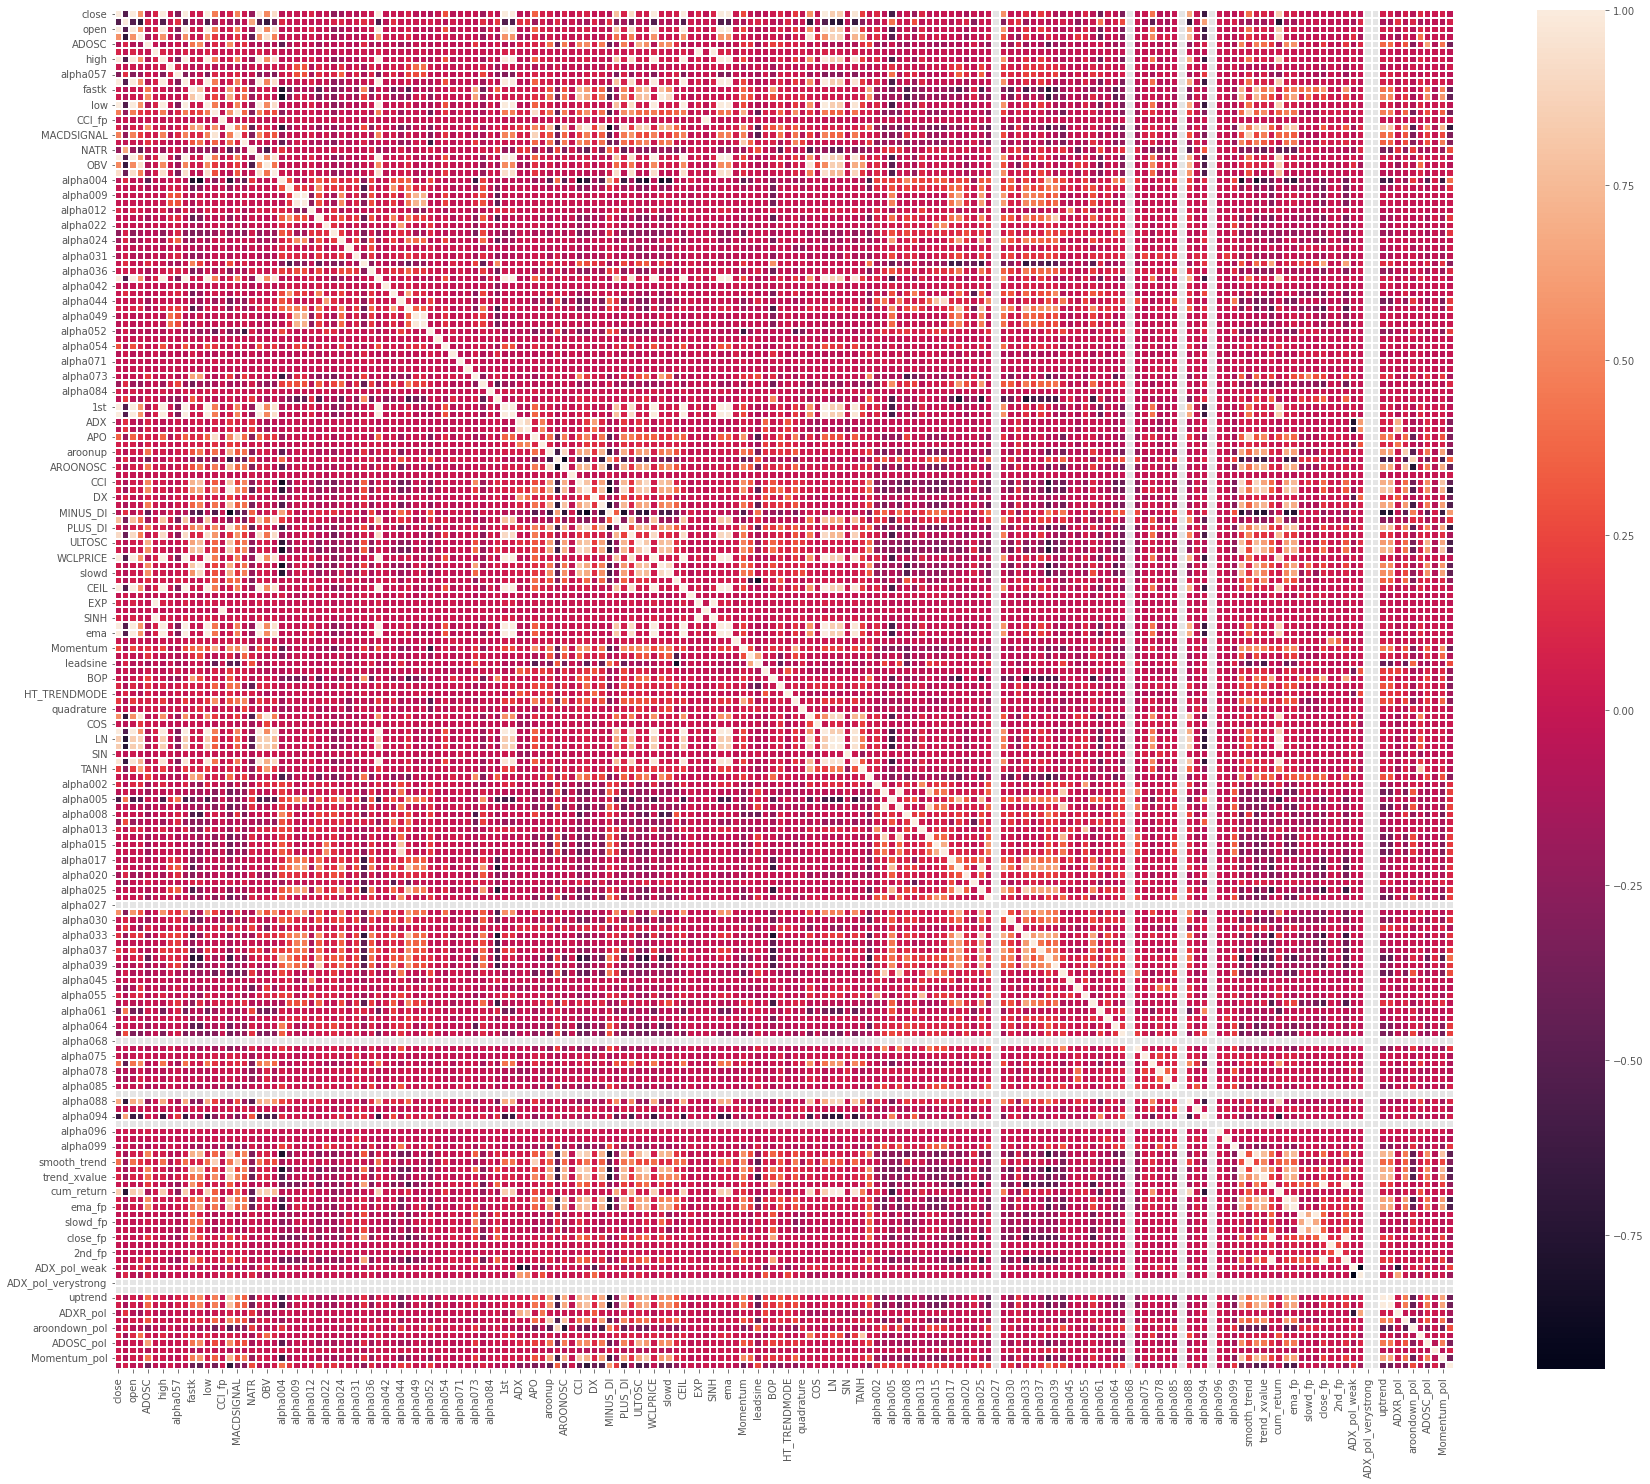

In [ ]:
plt.figure(figsize=(30, 25))
sns.heatmap(final_df.corr(),linewidths=1)

In [ ]:
cor_matrix = final_df.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
upper_tri

,close,volume,open,AD,ADOSC,COSH,high,alpha046,alpha057,adj close,fastk,fastd,low,MACD,CCI_fp,RSI,MACDSIGNAL,MACDHIST,NATR,LINEARREG,OBV,ATR,alpha004,alpha007,alpha009,alpha010,alpha012,alpha019,alpha022,alpha023,alpha024,alpha029,alpha031,alpha035,alpha036,alpha041,alpha042,alpha043,alpha044,alpha047,...,alpha078,alpha081,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,short_target,smooth_trend,trend_value,trend_xvalue,returns,cum_return,sma_fp,ema_fp,slowk_fp,slowd_fp,fastd_fp,close_fp,1st_fp,2nd_fp,adj close_fp,ADX_pol_weak,ADX_pol_strong,ADX_pol_verystrong,ADX_pol_extreme,uptrend,downtrend,ADXR_pol,aroonup_pol,aroondown_pol,AD_pol,ADOSC_pol,willr_pol,Momentum_pol,RSI_pol
close,NaN,0.517315,0.999824,0.561934,0.085366,0.091854,0.999912,0.027654,0.292624,0.999734,0.036279,0.043212,0.999913,0.463560,0.025852,0.086564,0.490879,0.021331,0.200771,0.999769,0.522621,0.927567,0.048607,0.000936,0.000486,0.002176,0.102922,0.028591,0.000471,0.242774,0.164907,0.030043,0.085123,0.009654,0.033992,0.999941,0.009038,0.019359,0.000437,0.085855,...,0.076616,0.054686,0.011824,NaN,0.666914,0.004098,0.630115,NaN,0.020688,0.018851,0.055246,0.063833,0.413316,0.057182,0.104409,0.013989,0.840691,0.062795,0.059796,0.018452,0.015918,0.018452,0.013989,0.000164,0.002040,0.014383,0.049594,0.036136,NaN,NaN,0.063711,0.063711,0.072377,0.065490,0.069825,0.125612,0.025003,0.024979,0.060164,0.035174
volume,NaN,NaN,0.516970,0.691424,0.098620,0.020888,0.515725,0.014670,0.154781,0.507131,0.077632,0.089201,0.518852,0.215201,0.018079,0.158527,0.222658,0.028292,0.655362,0.516897,0.653073,0.397610,0.125598,0.002374,0.002696,0.001667,0.033739,0.006772,0.005625,0.089135,0.109239,0.016613,0.064108,0.152812,0.045607,0.517313,0.054783,0.147595,0.013431,0.024011,...,0.077949,0.148897,0.015063,NaN,0.685192,0.017293,0.623458,NaN,0.029166,0.011500,0.068053,0.142005,0.189908,0.125527,0.171980,0.025826,0.736875,0.124146,0.141277,0.013780,0.009523,0.013780,0.025826,0.032774,0.020525,0.026886,0.144348,0.110274,NaN,NaN,0.123950,0.123950,0.165543,0.068227,0.098757,0.147567,0.041729,0.027545,0.085058,0.070476
open,NaN,NaN,NaN,0.561857,0.086800,0.091225,0.999925,0.030657,0.287873,0.999555,0.029308,0.040465,0.999909,0.462771,0.025501,0.083225,0.490649,0.019165,0.200255,0.999816,0.522581,0.927913,0.045705,0.005687,0.008207,0.010754,0.102785,0.023915,0.001633,0.239041,0.156231,0.029926,0.082372,0.002420,0.039434,0.999946,0.008705,0.023610,0.001509,0.094057,...,0.076267,0.054301,0.010798,NaN,0.668782,0.004345,0.628872,NaN,0.020560,0.018782,0.054226,0.059653,0.413336,0.052213,0.102157,0.005583,0.840523,0.062001,0.060191,0.022231,0.017592,0.022231,0.005583,0.000677,0.002485,0.005990,0.050100,0.036669,NaN,NaN,0.061967,0.061967,0.072842,0.065230,0.070125,0.125606,0.022508,0.025442,0.058090,0.032775
AD,NaN,NaN,NaN,NaN,0.126738,0.022428,0.561393,0.014982,0.168956,0.546766,0.020025,0.025025,0.562494,0.193782,0.021600,0.030866,0.207219,0.001820,0.435885,0.561788,0.942752,0.477181,0.009392,0.010057,0.000151,0.002915,0.046666,0.009876,0.000177,0.122396,0.107234,0.022813,0.083691,0.005616,0.007856,0.561960,0.033946,0.009209,0.040189,0.131628,...,0.050008,0.092514,0.018106,NaN,0.751467,0.018718,0.542846,NaN,0.033488,0.027061,0.056066,0.050658,0.174103,0.043468,0.053643,0.009241,0.879632,0.009373,0.011075,0.012485,0.015675,0.012485,0.009241,0.028696,0.027098,0.008137,0.144686,0.135078,NaN,NaN,0.027715,0.027715,0.172067,0.044589,0.035600,0.413793,0.001301,0.012782,0.020830,0.018902
ADOSC,NaN,NaN,NaN,NaN,NaN,0.002747,0.086531,0.013495,0.042978,0.082885,0.433055,0.534627,0.085934,0.119908,0.008846,0.533801,0.081440,0.165752,0.089997,0.085883,0.070388,0.096403,0.449740,0.101877,0.007001,0.004724,0.020853,0.151220,0.031426,0.056499,0.012851,0.055778,0.076643,0.132983,0.128175,0.086232,0.008920,0.029480,0.167393,0.126482,...,0.087428,0.014819,0.111859,NaN,0.235157,0.017670,0.073696,NaN,0.071479,0.009580,0.112504,0.497857,0.077657,0.485675,0.418033,0.191170,0.121855,0.526731

In [ ]:
# Drop out highly correlated features of threshold 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)] 
print(); print(to_drop,len(to_drop))


['open', 'high', 'adj close', 'low', 'CCI_fp', 'MACDSIGNAL', 'LINEARREG', 'alpha010', 'alpha041', 'alpha051', '1st', '2nd', 'CMO', 'WCLPRICE', 'slowk', 'CEIL', 'EXP', 'CCI_fp', 'SINH', 'sma', 'ema', 'ATAN', 'FLOOR', 'LOG10', 'SQRT', 'alpha006', 'short_target', 'cum_return', 'fastd_fp', 'close_fp', 'adj close_fp', 'downtrend'] 32


In [ ]:
df_cor = final_df.drop(columns=to_drop)
df_cor['trend_value'] = final_df['trend_value']
df_cor

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,close,volume,AD,ADOSC,COSH,alpha046,alpha057,fastk,fastd,MACD,RSI,MACDHIST,NATR,OBV,ATR,alpha004,alpha007,alpha009,alpha012,alpha019,alpha022,alpha023,alpha024,alpha029,alpha031,alpha035,alpha036,alpha042,alpha043,alpha044,alpha047,alpha049,alpha052,alpha053,alpha054,alpha066,alpha071,alpha072,alpha073,alpha083,...,alpha064,alpha065,alpha068,alpha074,alpha075,alpha077,alpha078,alpha081,alpha085,alpha086,alpha088,alpha092,alpha094,alpha095,alpha096,alpha098,alpha099,smooth_trend,trend_value,trend_xvalue,returns,sma_fp,ema_fp,slowk_fp,slowd_fp,1st_fp,2nd_fp,ADX_pol_weak,ADX_pol_strong,ADX_pol_verystrong,ADX_pol_extreme,uptrend,ADXR_pol,aroonup_pol,aroondown_pol,AD_pol,ADOSC_pol,willr_pol,Momentum_pol,RSI_pol
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2006-03-10,0.002496,0.299831,0.125807,0.221581,2.687208e-68,0.491604,0.999944,0.140420,0.094720,0.374820,0.190026,0.514924,0.290467,0.260341,0.006570,1.000,0.875000,0.493250,0.506768,0.933977,0.540119,0.669869,0.503697,0.280424,0.902942,0.065054,0.622866,4.062160e-04,0.672956,0.762144,0.141347,0.493250,0.505619,0.499960,2.671486e-12,0.366444,0.466667,0.000426,0.1250,0.999902,...,0,-1,0,0,0,0.081928,0.432197,0,0.998976,0,0.106863,7.0,-0.105714,1,-8.0,0.038946,-1,-0.113447,-0.500000,-0.500000,-0.011575,-0.006521,-0.008779,-0.301860,-0.061436,0.015495,-0.011475,0,1,1,0,0,1,0,1,1,-1,1,-1,0
2006-03-13,0.003070,0.245149,0.128181,0.245415,3.471760e-68,0.485073,0.991760,0.679999,0.277976,0.375031,0.305988,0.516458,0.282445,0.276275,0.006921,0.750,0.741667,0.485733,0.514267,0.940163,0.542011,0.669869,0.488705,0.693918,0.732688,0.272849,0.652743,2.316757e-04,0.496855,0.906147,0.048744,0.485733,0.502219,0.500085,5.399749e-24,0.508230,0.400000,0.000436,0.5000,0.970152,...,0,0,0,-1,0,0.080978,0.561423,-1,0.983021,0,0.084540,7.0,-0.020408,1,-7.0,0.245904,-1,-0.131893,0.290886,-0.209114,0.039405,-0.004636,-0.005714,1.775666,0.289462,-0.006876,-0.012956,0,1,1,0,0,1,0,1,1,-1,1,-1,0
2006-03-14,0.003449,0.179284,0.137275,0.322706,4.028721e-68,0.488147,0.981575,1.000000,0.612256,0.375784,0.372421,0.518932,0.266201,0.288154,0.006509,0.250,0.491667,0.493051,0.506949,0.055040,0.511555,0.669869,0.488517,0.671411,0.685966,0.096102,0.697025,2.294834e-04,0.037736,0.975358,0.025005,0.493051,0.501247,0.499936,1.312537e-24,0.649031,0.400000,0.000588,0.8125,0.978476,...,0,0,0,-1,0,0.080503,0.660575,-1,0.990871,0,0.061981,6.0,-0.235476,1,-8.0,0.398361,0,-0.141839,0.482477,-0.017523,0.024970,-0.004482,-0.003560,1.166939,0.879855,-0.013444,-0.015699,0,1,1,0,0,1,0,1,1,-1,1,-1,0
2006-03-15,0.003197,0.254408,0.131760,0.335516,3.654858e-68,0.491604,0.999981,0.676207,0.794952,0.376113,0.335918,0.519936,0.272450,0.271650,0.006533,0.125,0.650000,0.500946,0.514465,0.934293,0.511984,0.669869,0.496170,0.051170,0.830386,0.043548,0.594472,4.675196e-04,0.559748,0.778429,0.144942,0.496475,0.502839,0.499859,5.403860e-12,0.792344,0.333333,0.001139,0.9375,0.999880,...,0,0,0,0,0,0.079791,0.710293,-1,0.926578,0,0.097127,3.0,-0.002553,1,-4.0,0.400617,0,-0.135822,0.355139,-0.144861,-0.016192,-0.005134,0.000745,0.294321,0.693023,-0.011475,-0.020430,0,1,1,0,0,1,0,1,1,-1,1,-1,0
2006-03-16,0.002754,0.211626,0.121223,0.293519,3.031307e-68,0.491604,0.999987,0.332739,0.676541,0.375850,0.276508,0.519377,0.284458,0.257780,0.006602,0.750,0.491667,0.493241,0.506759,0.920217,0.518767,0.669869,0.503633,0.464664,0.883146,0.024194,0.747834,4.647150e-04,0.654088,0.785305,0.122992,0.496475,0.501350,0.499961,4.727626e-12,0.929786,0.266667,0.004025,0.6875,0.999881,...,0,0,0,0,0,0.079079,0.642506,-1,0.779882,0,0.124673,1.0,-0.023438,1,-8.0,0.272738,0,-0.135536,0.135429,-0.364571,-0.028990,-0.006232,-0.001056,-0.147381,0.232993,-0.012956,-0.010074,0,1,1,0,0,0,0,1,1,-1,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Recursive Feature Elimination

In [ ]:
# Build a classification task using 10 informative features from 175 features

df_ref = df_cor
df_ref = df_ref.dropna()
df_ref.index = range(0,len(df_ref))
#df_ref = df_ref.drop('timestamp',axis=1)

#Final checking if dataset contains 'infinity' or 'nan' points and drop of them before RFE
count = np.isinf(df_ref).values.sum()
print("It contains " + str(count) + " infinite values")

print("printing column name where infinity is present")
col_name = df_ref.columns.to_series()[np.isinf(df_ref).any()]
print(col_name)
# printing row index with infinity
print()
print("printing row index with infinity ")
  
r = df_ref.index[np.isinf(df_ref).any(1)]
print(r)

df_ref.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
df_ref = df_ref.dropna()

# Training dataset for RFECV
X = df_ref.drop('trend_xvalue',axis=1)
X_train = X[0:int(0.75*(len(X)))]
X_test = X[int(0.75*(len(X))):]
#X = X[['close','volume','open','high','lo66w']]
# y label
y = df_ref['trend_xvalue']
y_train= y[0:int(0.75*(len(y)))]
y_test = y[int(0.75*(len(X))):]

It contains 0 infinite values
printing column name where infinity is present
Series([], dtype: object)

printing row index with infinity 
Int64Index([], dtype='int64')


In [ ]:
X = df_ref.drop('trend_xvalue',axis=1)
y = df_ref['trend_xvalue']

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
#from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
#svr1=SVR(kernel="linear", C=3)
#rfecv1 = RFECV(estimator=svr1, step=5, cv= 5, scoring='accuracy', verbose=1, min_features_to_select=20, n_jobs=4)  # Stratified fold inorder to reduce bias
#rfetrain1 = rfecv1.fit(x_train1, y_train)
estimator = SVR(kernel="linear",C=3)
rfetrain1 = RFECV(estimator, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain1 = rfetrain1.fit(X, y)
print('Optimal number of features :', rfetrain1.n_features_)

It contains 0 infinite values


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4389: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


ValueError: ignored

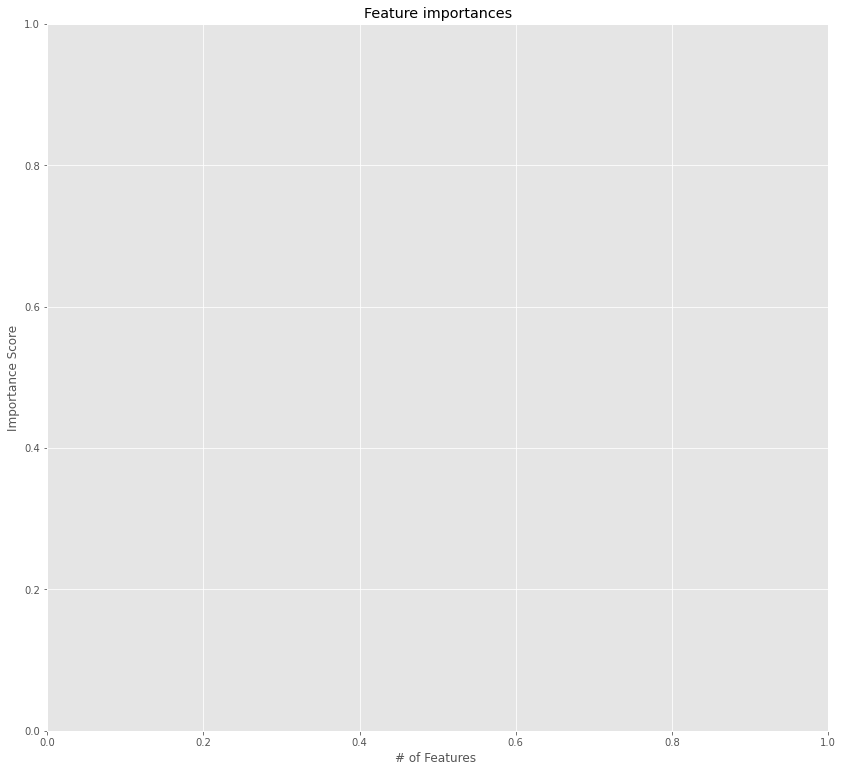

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Bagged decision trees for feature importance- embedded method
count = np.isinf(X_train).values.sum()
print("It contains " + str(count) + " infinite values")
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
  
# Dropping all the rows with nan values
X_train = X_train.dropna()

Rtree_clf = RandomForestClassifier()
Rtree_clf = Rtree_clf.fit(X_train,y_train)
model = SelectFromModel(Rtree_clf, prefit=True)
RF_tree_featuresTrain=X_train.loc[:, model.get_support()]
RF_tree_featuresTest = X_test.loc[:, model.get_support()]


# Based on Feature Selection only 87 features were selected

# Feature Importance

# Important scores
# for name, importance in zip(df_traindata, Rtree_clf.feature_importances_):
#     print(name, "=", importance)

importances = Rtree_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rtree_clf.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
indices.shape
indices = indices[:200]

# Feature Ranking
#print("Feature ranking:")
#for f in range(200):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.xlabel("# of Features ")
plt.ylabel("Importance Score")
plt.bar(range(200), importances[indices],color="r", yerr=std[indices], align="center")
plt.xlim([0, 200])
plt.show()

In [ ]:
RF_tree_featuresTrain

,NATR,OBV,ATR,Target,ADX,HT_DCPERIOD,CORREL,ADXR,MINUS_DI,MINUS_DM,PLUS_DM,TRIX,AD,COS,SIN,TAN,alpha032,alpha078,alpha088,1st_fp,2nd_fp
0,0.233989,0.343104,0.007491,-1,29.090490,20.367490,0.971043,28.792612,28.214577,0.366706,0.361625,0.584290,9.849171e+09,-0.933170,0.359436,-0.385178,0.003164,0.823108,0.145571,-0.023430,0.014497
1,0.250361,0.321970,0.008102,0,27.147547,20.518352,0.968874,27.552062,26.078439,0.348727,0.335795,0.578289,8.875909e+09,-0.910676,0.413121,-0.453642,0.003530,0.753106,0.160532,-0.018017,0.015233
2,0.273309,0.298365,0.009018,0,26.212581,20.344060,0.964762,26.610144,29.696436,0.413818,0.311809,0.569563,8.170480e+09,-0.881582,0.472031,-0.535436,0.003482,0.703803,0.164806,0.003660,-0.012836
3,0.299572,0.284732,0.010931,-1,24.133571,20.130698,0.955141,26.192328,26.438704,0.399500,0.356795,0.528455,7.632364e+09,-0.894707,0.446654,-0.499218,0.003200,0.585806,0.110900,0.016731,-0.072995
4,0.293031,0.301635,0.010680,-1,22.813069,20.006634,0.954203,26.448969,24.803531,0.370964,0.331310,0.512952,7.960390e+09,-0.902694,0.430283,-0.476666,0.003434,0.636976,0.083353,-0.016410,-0.014704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2668,0.065317,0.866504,0.122797,0,24.581986,20.308862,0.944002,24.534425,28.606110,2.398102,2.206638,0.017336,6.058745e+10,0.998253,-0.059078,-0.059182,0.005578,0.189969,0.785324,-0.001136,0.013700
2669,0.061695,0.865230,0.118625,1,23.123128,20.843199,0.940823,23.286104,27.400539,2.226809,2.049021,0.019224,6.055964e+10,0.947934,-0.318467,-0.335959,0.005015,0.198975,0.907148,0.017043,0.003560
2670,0.061905,0.863761,0.118128,1,22.196804,21.779587,0.938829,22.233824,28.812246,2.332751,1.902662,0.020791,6.052356e+10,0.869497,-0.493938,-0.568073,0.005348,0.124704,0.960817,0.015003,0.009580
2671,0.058289,0.866378,0.116080,1,21.336646,22.862111,0.940418,21.412390,27.176540,2.166126,1.766758,0.022312,6.063846e+10,0.982639,-0.185530,-0.188808,0.004483,0.133157,0.887200,0.013700,0.009826


In [ ]:
x_train1 = X_train[X_train.columns[0:30]]
x_train2 = X_train[X_train.columns[30:60]]
x_train3 = X_train[X_train.columns[60:90]]
x_train4 = X_train[X_train.columns[90:120]]
x_train5 = X_train[X_train.columns[120:]]

In [ ]:
sub_col = []
grid_score = {}
rank_score = {}

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
#from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
#svr1=SVR(kernel="linear", C=3)
#rfecv1 = RFECV(estimator=svr1, step=5, cv= 5, scoring='accuracy', verbose=1, min_features_to_select=20, n_jobs=4)  # Stratified fold inorder to reduce bias
#rfetrain1 = rfecv1.fit(x_train1, y_train)
estimator = SVR(kernel="linear")
rfetrain1 = RFECV(estimator, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain1 = rfetrain1.fit(x_train1, y_train)
print('Optimal number of features :', rfetrain1.n_features_)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Optimal number of features : 5


In [ ]:
print('Optimal number of features :', rfetrain1.n_features_)

Optimal number of features : 5


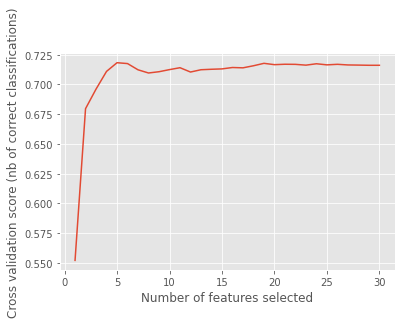

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfetrain1.grid_scores_) + 1), rfetrain1.grid_scores_)
plt.show()

In [ ]:
sub_col1 = []
grid_score['grid_score'+str(1)] = rfetrain1.grid_scores_
rank_score['rank_score'+str(1)] = rfetrain1.ranking_
df_rank1 = pd.DataFrame(rfetrain1.ranking_,index=x_train1.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(1),rfetrain1.ranking_)
print('Grid Score for set_'+str(1), rfetrain1.grid_scores_)
for j in range(len(df_rank1)):
  if(df_rank1['Rank'][j]==1):
    sub_col1.append(df_rank1.index[j])
print(x_train1.columns)
print(sub_col1)

Feature Ranking for set_1 [13  7 20 22 26 12  5  1  3  2  1  1  6 14 16  4 21  1 18 24 15  1 19 17
 10  8 11  9 25 23]
Grid Score for set_1 [0.55201756 0.67962965 0.69608757 0.7109825  0.71828643 0.71756137
 0.71232235 0.70964302 0.71071372 0.71248131 0.71408436 0.71045183
 0.71238068 0.71277511 0.71308359 0.71425571 0.71398407 0.71572161
 0.71776777 0.71664533 0.71699733 0.71690536 0.71624003 0.71740689
 0.71648214 0.71694406 0.71640526 0.71628423 0.71612563 0.71612563]
Index(['close', 'volume', 'AD', 'ADOSC', 'COSH', 'alpha046', 'alpha057',
       'fastk', 'fastd', 'MACD', 'RSI', 'MACDHIST', 'NATR', 'OBV', 'ATR',
       'alpha004', 'alpha007', 'alpha009', 'alpha012', 'alpha019', 'alpha022',
       'alpha023', 'alpha024', 'alpha029', 'alpha031', 'alpha035', 'alpha036',
       'alpha042', 'alpha043', 'alpha044'],
      dtype='object')
['fastk', 'RSI', 'MACDHIST', 'alpha009', 'alpha023']


In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
svc2=SVR(kernel="linear", C=3)
#rfecv2 = RFECV(estimator=svc2, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=1,min_features_to_select=20,n_jobs=4)  # Stratified fold inorder to reduce bias
rfecv2 = RFECV(svc2, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain2 = rfecv2.fit(x_train2, y_train)
print('Optimal number of features :', rfecv2.n_features_)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Optimal number of features : 19


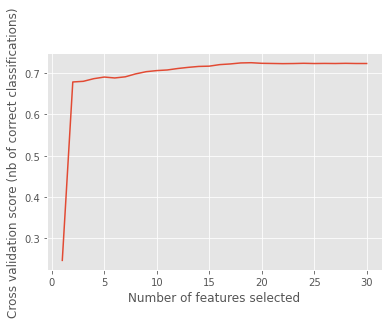

In [ ]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfetrain2.grid_scores_) + 1), rfetrain2.grid_scores_)
plt.show()

In [ ]:
sub_col2 = []
grid_score['grid_score'+str(2)] = rfetrain2.grid_scores_
rank_score['rank_score'+str(2)] = rfetrain2.ranking_
df_rank2 = pd.DataFrame(rfetrain2.ranking_,index=x_train2.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(2),rfetrain2.ranking_)
print('Grid Score for set_'+str(2), rfetrain2.grid_scores_)
for j in range(len(df_rank2)):
  if(df_rank2['Rank'][j]==1):
    sub_col2.append(df_rank2.index[j])
  
print(x_train2.columns)
print(sub_col2)

Feature Ranking for set_2 [ 1 11  1  1  5 10  8  1  3  1 12  1  1  1  1  6  2  1  1  9  1  4  1  1
  1  1  1  1  1  7]
Grid Score for set_2 [0.24679463 0.67819158 0.67974407 0.68614531 0.69006908 0.6878624
 0.69063689 0.69778214 0.70308784 0.70567426 0.70717283 0.71073076
 0.71351687 0.71575688 0.71642117 0.72013045 0.72175491 0.72419563
 0.72473589 0.72329522 0.72292245 0.72249012 0.72274999 0.72331998
 0.72279237 0.72303416 0.72280479 0.72322758 0.72282708 0.72282708]
Index(['alpha047', 'alpha049', 'alpha052', 'alpha053', 'alpha054', 'alpha066',
       'alpha071', 'alpha072', 'alpha073', 'alpha083', 'alpha084', 'alpha101',
       'ADX', 'ADXR', 'APO', 'HT_DCPERIOD', 'aroonup', 'aroondown', 'AROONOSC',
       'TAN', 'CCI', 'DX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'PLUS_DI', 'PLUS_DM',
       'ULTOSC', 'WILLR', 'slowd'],
      dtype='object')
['alpha047', 'alpha052', 'alpha053', 'alpha072', 'alpha083', 'alpha101', 'ADX', 'ADXR', 'APO', 'aroondown', 'AROONOSC', 'CCI', 'MFI', 'MINUS_DI', 'MI

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
svc31=SVR(kernel="linear", C=3)
#rfecv3 = RFECV(estimator=svc3, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=1,min_features_to_select=20,n_jobs=4)  # Stratified fold inorder to reduce bias
rfecv3 = RFECV(estimator, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain3 = rfecv3.fit(x_train3, y_train)
print('Optimal number of features :', rfecv3.n_features_)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Optimal number of features : 27


In [ ]:
sub_col3 = []
grid_score['grid_score'+str(3)] = rfetrain3.grid_scores_
rank_score['rank_score'+str(3)] = rfetrain3.ranking_
df_rank3 = pd.DataFrame(rfetrain3.ranking_,index=x_train3.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(3),rfetrain3.ranking_)
print('Grid Score for set_'+str(3), rfetrain3.grid_scores_)
for j in range(len(df_rank3)):
  if(df_rank3['Rank'][j]==1):
    sub_col3.append(df_rank3.index[j])

print(x_train3.columns)
print(sub_col3)

Feature Ranking for set_3 [1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 3 1 1 1 1 2 1 1 1 1 1 1 1]
Grid Score for set_3 [0.09759789 0.2371867  0.53926102 0.59754327 0.59776337 0.60150081
 0.60639439 0.62308614 0.62434312 0.62838957 0.63624178 0.64489599
 0.64555064 0.64523106 0.64443369 0.64621641 0.65092038 0.65184962
 0.65114509 0.6508871  0.65319691 0.65586689 0.656424   0.65561639
 0.65541974 0.65643039 0.65646754 0.6562332  0.65555268 0.65542274]
Index(['HT_DCPHASE', 'fastk_fp', 'Target', 'Momentum', 'sine', 'leadsine',
       'CORREL', 'BOP', 'TRIX', 'HT_TRENDMODE', 'inphase', 'quadrature', 'COS',
       'LN', 'SIN', 'TANH', 'alpha001', 'alpha002', 'alpha003', 'alpha005',
       'alpha008', 'alpha011', 'alpha013', 'alpha014', 'alpha015', 'alpha016',
       'alpha017', 'alpha018', 'alpha020', 'alpha021'],
      dtype='object')
['HT_DCPHASE', 'fastk_fp', 'Target', 'Momentum', 'sine', 'leadsine', 'CORREL', 'BOP', 'TRIX', 'HT_TRENDMODE', 'inphase', 'quadrature', 'LN', 'SIN', 'TANH', 'alpha001',

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
svc4=SVR(kernel="linear", C=3)
#rfecv4 = RFECV(estimator=svc4, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=1,min_features_to_select=20,n_jobs=4)  # Stratified fold inorder to reduce bias
rfecv4 = RFECV(svc4, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain4 = rfecv4.fit(x_train4, y_train)
print('Optimal number of features :', rfecv4.n_features_)

Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Optimal number of features : 27


In [ ]:
sub_col4 = []
grid_score['grid_score'+str(4)] = rfetrain4.grid_scores_
rank_score['rank_score'+str(4)] = rfetrain4.ranking_
df_rank4 = pd.DataFrame(rfetrain4.ranking_,index=x_train4.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(4),rfetrain4.ranking_)
print('Grid Score for set_'+str(4), rfetrain4.grid_scores_)
for j in range(len(df_rank4)):
  if(df_rank4['Rank'][j]==1):
    sub_col4.append(df_rank4.index[j])
  
print(x_train4.columns)
print(sub_col4)

Feature Ranking for set_4 [1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 4 1 1]
Grid Score for set_4 [0.13482716 0.35352622 0.37076292 0.40893687 0.42088222 0.42965877
 0.43079906 0.44206403 0.45262205 0.46318738 0.463699   0.46208743
 0.45870453 0.45945621 0.46302242 0.46275355 0.46083667 0.46267687
 0.46270432 0.46277738 0.46439293 0.46359989 0.46518011 0.4657493
 0.46622261 0.46719612 0.46829426 0.46817308 0.46817308 0.46817308]
Index(['alpha025', 'alpha026', 'alpha027', 'alpha028', 'alpha030', 'alpha032',
       'alpha033', 'alpha034', 'alpha037', 'alpha038', 'alpha039', 'alpha040',
       'alpha045', 'alpha050', 'alpha055', 'alpha060', 'alpha061', 'alpha062',
       'alpha064', 'alpha065', 'alpha068', 'alpha074', 'alpha075', 'alpha077',
       'alpha078', 'alpha081', 'alpha085', 'alpha086', 'alpha088', 'alpha092'],
      dtype='object')
['alpha025', 'alpha026', 'alpha028', 'alpha030', 'alpha032', 'alpha033', 'alpha034', 'alpha037', 'alpha038', 'alpha039', 'alpha040', 'alph

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 

# Applying RFECV with svm classifier
svc5=SVR(kernel="linear", C=3)
#rfecv5 = RFECV(estimator=svc5, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=1,min_features_to_select=20,n_jobs=4)  # Stratified fold inorder to reduce bias
rfecv5 =RFECV(svc5, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain5 = rfecv5.fit(x_train5, y_train)
print('Optimal number of features :', rfecv5.n_features_)

Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Optimal number of features : 25


In [ ]:
sub_col5 = []
grid_score['grid_score'+str(5)] = rfetrain5.grid_scores_
rank_score['rank_score'+str(5)] = rfetrain5.ranking_
df_rank5 = pd.DataFrame(rfetrain5.ranking_,index=x_train5.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(5),rfetrain5.ranking_)
print('Grid Score for set_'+str(5), rfetrain5.grid_scores_)
for j in range(len(df_rank5)):
  if(df_rank5['Rank'][j]==1):
    sub_col5.append(df_rank5.index[j])

print(x_train5.columns)
print(sub_col5)

Feature Ranking for set_5 [1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 4 1 1 1 1 1 1 1 1 1 1]
Grid Score for set_5 [0.18028232 0.33234945 0.5467599  0.66033558 0.66071254 0.693168
 0.71567281 0.73048796 0.73587086 0.74448116 0.74993633 0.75535327
 0.75449851 0.75615138 0.75620194 0.75562237 0.75511199 0.75565705
 0.75596739 0.75556976 0.75578964 0.75675374 0.75627325 0.75652364
 0.75707525 0.75705427 0.75705424 0.75705424]
Index(['alpha094', 'alpha095', 'alpha096', 'alpha098', 'alpha099',
       'short_target', 'smooth_trend', 'returns', 'sma_fp', 'ema_fp',
       'slowk_fp', 'slowd_fp', '1st_fp', '2nd_fp', 'ADX_pol_weak',
       'ADX_pol_strong', 'ADX_pol_verystrong', 'ADX_pol_extreme', 'uptrend',
       'ADXR_pol', 'aroonup_pol', 'aroondown_pol', 'AD_pol', 'ADOSC_pol',
       'willr_pol', 'Momentum_pol', 'RSI_pol', 'trend_value'],
      dtype='object')
['alpha094', 'alpha096', 'alpha098', 'alpha099', 'short_target', 'smooth_trend', 'returns', 'sma_fp', 'ema_fp', 'slowk_fp', 'slowd_fp', '1st_fp

In [ ]:
reduced_col = sub_col1 + sub_col2 + sub_col3 + sub_col4 + sub_col5
red_X = X_train[reduced_col]
red_X

,fastk,RSI,MACDHIST,alpha009,alpha023,alpha047,alpha052,alpha053,alpha072,alpha083,alpha101,ADX,ADXR,APO,aroondown,AROONOSC,CCI,MFI,MINUS_DI,MINUS_DM,PLUS_DI,PLUS_DM,ULTOSC,WILLR,HT_DCPHASE,fastk_fp,Target,Momentum,sine,leadsine,CORREL,BOP,TRIX,HT_TRENDMODE,inphase,quadrature,LN,SIN,TANH,alpha001,...,alpha050,alpha055,alpha060,alpha061,alpha062,alpha064,alpha065,alpha074,alpha075,alpha077,alpha078,alpha081,alpha085,alpha088,alpha092,alpha094,alpha096,alpha098,alpha099,short_target,smooth_trend,returns,sma_fp,ema_fp,slowk_fp,slowd_fp,1st_fp,2nd_fp,ADX_pol_weak,ADX_pol_strong,uptrend,ADXR_pol,aroonup_pol,aroondown_pol,AD_pol,ADOSC_pol,willr_pol,Momentum_pol,RSI_pol,trend_value
0,0.692001,0.422260,0.525572,0.501428,0.667966,0.070589,0.499618,0.499883,0.000411,0.999739,0.821226,0.258435,0.229939,0.413092,0.357143,0.785714,0.648369,0.405222,0.335586,0.011695,0.235106,0.007202,0.519931,0.847525,0.321936,0.000879,-1,0.232500,0.946070,0.898048,0.979145,-0.402373,0.139268,1,0.125089,0.048867,0.936933,0.555904,0.987932,0.535153,...,-0.609698,-0.773176,0.000177,1,0,-1,0,0,1,0.088103,0.688894,0,0.836120,0.049157,6.0,-0.329048,-7.0,0.532653,-1,0.891387,-0.021405,-0.004042,-0.002494,0.003434,0.005569,-0.019110,-0.011188,-0.017536,1,0,0,0,1,1,1,1,1,1,0,0.891387
1,0.598000,0.405806,0.525620,0.493241,0.671241,0.104978,0.498537,0.499962,0.000524,0.999788,0.796010,0.243713,0.231243,0.414283,0.285714,0.785714,0.595267,0.433041,0.346644,0.011587,0.221955,0.006392,0.451628,0.800989,0.343539,0.000823,-1,0.131428,0.981160,0.830397,0.974560,-0.680267,0.124522,1,0.121124,-0.057290,0.930334,0.569778,0.987522,0.357364,...,-0.490611,-0.683739,0.000250,1,0,-1,0,0,1,0.089052,0.720762,0,0.946699,0.069105,4.0,-0.238095,-7.0,0.275944,-1,0.715354,0.001857,-0.006577,-0.000678,0.002683,-0.139553,-0.062949,-0.006616,-0.016271,1,0,0,0,1,1,1,-1,1,1,0,0.715354
2,0.098000,0.324286,0.523729,0.493243,0.670633,0.150465,0.497330,0.499873,0.000922,0.999882,0.927035,0.245547,0.242729,0.415707,0.214286,0.785714,0.511295,0.436181,0.420626,0.014715,0.186475,0.005639,0.300490,0.553463,0.389967,0.000156,0,0.135000,0.995321,0.635475,0.969275,-0.718612,0.110022,0,0.061565,-0.101323,0.894483,0.640786,0.985101,0.202931,...,-0.490611,-0.321237,0.000061,1,0,-1,0,-1,1,0.089290,0.775320,0,0.982600,0.086440,2.0,-0.001942,-7.0,0.184873,0,0.000000,0.020548,-0.035216,-0.000111,0.001546,-0.319608,-0.143269,-0.003716,-0.010325,1,0,0,0,1,0,1,-1,1,1,0,-0.500000
3,0.216865,0.348165,0.522917,0.485357,0.669869,0.036861,0.500199,0.499975,0.001437,0.978358,0.996540,0.247693,0.256602,0.416867,0.142857,0.785714,0.467823,0.365387,0.405505,0.013633,0.175285,0.004940,0.313236,0.613860,0.442715,0.002107,-1,0.052143,0.909958,0.350200,0.958904,0.176876,0.096099,0,0.043764,-0.018070,0.903350,0.623910,0.985732,0.064585,...,-0.490611,-0.288522,-0.000641,1,0,0,0,0,0,0.087865,0.820047,0,0.935344,0.066967,1.0,-0.007067,-7.0,0.176086,0,0.187118,0.028524,0.008907,0.000010,-0.003817,-0.342317,-0.251428,-0.017536,-0.007850,1,0,0,0,1,0,1,-1,1,1,0,0.187118
4,0.326486,0.368496,0.522746,0.493182,0.669869,0.033470,0.500763,0.499961,0.001659,0.968393,0.997745,0.244923,0.269765,0.418457,0.071429,0.785714,0.485744,0.434349,0.388330,0.012499,0.189726,0.005058,0.401932,0.664355,0.509803,0.001434,-1,0.013928,0.661194,-0.062947,0.945931,0.469677,0.082980,0,0.064686,-0.037843,0.910704,0.609573,0.986239,0.816254,...,-0.490611,-0.018489,-0.000635,1,-1,0,-1,0,1,0.087628,0.857561,0,0.899479,0.048207,1.0,-0.254286,-7.0,-0.013061,-1,0.377102,0.021429,0.007380,0.000922,-0.003038,-0.297431,-0.322205,-0.016271,-0.015926,1,0,0,1,1,0,1,-1,1,1,0,0.377102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,0.738899,0.534748,0.504345,0.622548,0.661790,0.139321,0.50277

In [ ]:
red_X
x_train6 = red_X[red_X.columns[0:50]]
x_train7 = red_X[red_X.columns[50:]]

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 
x_train6 = red_X[red_X.columns[0:50]]
# Applying RFECV with svm classifier
svc6=SVR(kernel="linear", C=3)
#rfecv6 = RFECV(estimator=svc6, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=1,min_features_to_select=30,n_jobs=4)  # Stratified fold inorder to reduce bias
rfecv6 = RFECV(svc6, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain6 = rfecv6.fit(x_train6, y_train)
print('Optimal number of features :', rfecv6.n_features_)

Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 fe

In [ ]:
sub_col6 = []
grid_score['grid_score'+str(6)] = rfetrain6.grid_scores_
rank_score['rank_score'+str(6)] = rfetrain6.ranking_
df_rank6 = pd.DataFrame(rfetrain6.ranking_,index=x_train6.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(6),rfetrain6.ranking_)
print('Grid Score for set_'+str(6), rfetrain6.grid_scores_)
for j in range(len(df_rank6)):
  if(df_rank6['Rank'][j]==1):
    sub_col6.append(df_rank6.index[j])

print(x_train6.columns)
print(sub_col6)

Feature Ranking for set_6 [ 1  1  3  1  1 22 29  1  1  1 28  1  7  1 12  1  1  1  4  6  1  5  1  1
 19  1 24  9  1  1  1 16 11 20  8 21 13 27  1 14 30 15 10 25 17 26 18 23
  1  2]
Grid Score for set_6 [0.62083558 0.62263066 0.68692613 0.72715263 0.73902929 0.73818373
 0.7440692  0.74990663 0.75843015 0.76473991 0.7648662  0.76850184
 0.76812154 0.77122006 0.77110897 0.7715028  0.77157776 0.77153466
 0.7712195  0.77222749 0.77278381 0.772591   0.7704611  0.77077689
 0.77035922 0.77014693 0.76986947 0.76949962 0.7685959  0.76820316
 0.76834877 0.76783475 0.76757633 0.76835482 0.76907415 0.7690981
 0.77005838 0.77083519 0.77093236 0.77063016 0.77073445 0.77075275
 0.77014295 0.77011084 0.77027424 0.77023079 0.77000996 0.76999853
 0.77007287 0.77006896]
Index(['fastk', 'RSI', 'MACDHIST', 'alpha009', 'alpha023', 'alpha047',
       'alpha052', 'alpha053', 'alpha072', 'alpha083', 'alpha101', 'ADX',
       'ADXR', 'APO', 'aroondown', 'AROONOSC', 'CCI', 'MFI', 'MINUS_DI',
       'MINUS_DM', 'PL

In [ ]:
# Applying RFE Cross validation to find number of features
# The "accuracy" scoring is proportional to the number of correct classifications
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
# Before we apply RFE we need to know the optimal number of features. Hence RFECV crossvalidation technique is used to find 
# the optimal number of features based on the accuracy score in the training set. 
x_train7 = red_X[red_X.columns[50:]]
# Applying RFECV with svm classifier
svc7=SVR(kernel="linear", C=3)
#rfecv7 = RFECV(estimator=svc7, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=1,min_features_to_select=30,n_jobs=4)  # Stratified fold inorder to reduce bias
rfecv7 = RFECV(svc7, step=1, cv=5, n_jobs=4,verbose=1)
rfetrain7 = rfecv7.fit(x_train7, y_train)
print('Optimal number of features :', rfecv7.n_features_)

Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Optimal number of features : 27


In [ ]:
sub_col7 = []
grid_score['grid_score'+str(7)] = rfetrain7.grid_scores_
rank_score['rank_score'+str(7)] = rfetrain7.ranking_
df_rank7 = pd.DataFrame(rfetrain7.ranking_,index=x_train7.columns,columns=['Rank'])
print('Feature Ranking for set_'+str(7),rfetrain7.ranking_)
print('Grid Score for set_'+str(7), rfetrain7.grid_scores_)
for j in range(len(df_rank7)):
  if(df_rank7['Rank'][j]==1):
    sub_col7.append(df_rank7.index[j])

print(x_train7.columns)
print(sub_col7)

Feature Ranking for set_7 [21  1 14 11  1  1 17  9  1  1 24  7 19  1  1  3 26 12 22 15  8 16  1  1
 25  6  4 27  5 18  1 23  1  1  1  1  1 10  1  1  1  1  1  1 13  1  1  2
 20  1  1  1  1]
Grid Score for set_7 [0.18028232 0.33234945 0.5467599  0.66033558 0.66071254 0.693168
 0.71074111 0.72141759 0.7315824  0.73516118 0.74268635 0.74798016
 0.74792242 0.75167287 0.75272684 0.75531524 0.7562349  0.75563653
 0.75692264 0.75759042 0.75834406 0.7584997  0.75796082 0.75862576
 0.75801081 0.75847793 0.75963889 0.75950085 0.75909317 0.75898421
 0.75882171 0.75929881 0.75885426 0.75819172 0.75787291 0.75696074
 0.75785841 0.75710875 0.75767489 0.75751723 0.75694718 0.75737417
 0.75762071 0.75759596 0.7575668  0.75779387 0.7571079  0.75631285
 0.75646699 0.75636794 0.75657504 0.75661896 0.75684141]
Index(['alpha021', 'alpha025', 'alpha026', 'alpha028', 'alpha030', 'alpha032',
       'alpha033', 'alpha034', 'alpha037', 'alpha038', 'alpha039', 'alpha040',
       'alpha045', 'alpha050', 'alpha055'

In [ ]:
rfecv_col = sub_col6 + sub_col7
df_rfecv = X[rfecv_col]
rfecv_xtrain = df_rfecv[0:int(0.75*(len(X)))]
rfecv_xtest = df_rfecv[int(0.75*(len(X))):]
df_rfecv

,fastk,RSI,alpha009,alpha023,alpha053,alpha072,alpha083,ADX,APO,AROONOSC,CCI,MFI,PLUS_DI,ULTOSC,WILLR,fastk_fp,sine,leadsine,CORREL,TANH,alpha018,alpha025,alpha030,alpha032,alpha037,alpha038,alpha050,alpha055,alpha077,alpha078,alpha098,short_target,smooth_trend,returns,sma_fp,ema_fp,slowd_fp,1st_fp,2nd_fp,ADX_pol_weak,ADX_pol_strong,uptrend,aroonup_pol,aroondown_pol,willr_pol,Momentum_pol,RSI_pol,trend_value
0,0.692001,0.422260,0.501428,0.667966,0.499883,0.000411,0.999739,0.258435,0.413092,0.785714,0.648369,0.405222,0.235106,0.519931,0.847525,0.000879,0.946070,0.898048,0.979145,0.987932,-0.425643,0.562023,0.089598,0.001888,1.288410,-0.381890,-0.609698,-0.773176,0.088103,0.688894,0.532653,0.891387,-0.021405,-0.004042,-0.002494,0.003434,-0.019110,-0.011188,-0.017536,1,0,0,1,1,1,1,0,0.891387
1,0.598000,0.405806,0.493241,0.671241,0.499962,0.000524,0.999788,0.243713,0.414283,0.785714,0.595267,0.433041,0.221955,0.451628,0.800989,0.000823,0.981160,0.830397,0.974560,0.987522,-0.426358,0.565124,0.095552,0.001982,1.261178,-0.299467,-0.490611,-0.683739,0.089052,0.720762,0.275944,0.715354,0.001857,-0.006577,-0.000678,0.002683,-0.062949,-0.006616,-0.016271,1,0,0,1,1,1,1,0,0.715354
2,0.098000,0.324286,0.493243,0.670633,0.499873,0.000922,0.999882,0.245547,0.415707,0.785714,0.511295,0.436181,0.186475,0.300490,0.553463,0.000156,0.995321,0.635475,0.969275,0.985101,-0.410629,0.609971,0.196101,0.002036,1.235959,-0.221339,-0.490611,-0.321237,0.089290,0.775320,0.184873,0.000000,0.020548,-0.035216,-0.000111,0.001546,-0.143269,-0.003716,-0.010325,1,0,0,1,0,1,1,0,-0.500000
3,0.216865,0.348165,0.485357,0.669869,0.499975,0.001437,0.978358,0.247693,0.416867,0.785714,0.467823,0.365387,0.175285,0.313236,0.613860,0.002107,0.909958,0.350200,0.958904,0.985732,-0.521449,0.461355,0.103642,0.001829,1.115337,-0.111312,-0.490611,-0.288522,0.087865,0.820047,0.176086,0.187118,0.028524,0.008907,0.000010,-0.003817,-0.251428,-0.017536,-0.007850,1,0,0,1,0,1,1,0,0.187118
4,0.326486,0.368496,0.493182,0.669869,0.499961,0.001659,0.968393,0.244923,0.418457,0.785714,0.485744,0.434349,0.189726,0.401932,0.664355,0.001434,0.661194,-0.062947,0.945931,0.986239,-0.520496,0.461594,0.097425,0.002003,1.070429,-0.131632,-0.490611,-0.018489,0.087628,0.857561,-0.013061,0.377102,0.021429,0.007380,0.000922,-0.003038,-0.322205,-0.016271,-0.015926,1,0,0,1,0,1,1,0,0.377102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,0.099300,0.403145,0.009581,0.669869,0.500122,0.000174,0.898995,0.180220,0.571643,0.714286,0.395745,0.550257,0.299837,0.243610,0.260786,0.002998,0.111293,-0.624018,0.919663,1.000000,-0.999523,0.023855,0.030093,0.002546,0.988033,-0.083484,-0.804849,0.299462,0.439801,0.865445,-0.149964,0.075130,4.054670,0.003893,0.000573,-0.001755,-0.369134,-0.001701,-0.012243,1,0,0,1,1,1,1,0,0.075130
3553,0.119446,0.356619,0.976901,0.669869,0.499960,0.000426,0.999988,0.171020,0.569755,0.714286,0.353494,0.470196,0.258885,0.211125,0.123681,0.001145,-0.261532,-0.867427,0.912112,1.000000,-0.000953,0.978531,0.149930,0.004949,1.489172,-0.000426,-0.804849,0.181175,0.501306,0.724558,-0.251603,0.000000,2.758004,-0.009562,0.000098,-0.001768,-0.484170,-0.004619,-0.000486,1,0,0,1,0,1,-1,0,-0.500000
3554,0.273101,0.390389,0.011263,0.669869,0.498938,0.000347,0.908059,0.165593,0.564512,0.285714,0.340455,0.459315,0.231824,0.274897,0.244261,0.002177,-0.670728,-0.998740,0.909861,1.000000,-1.000000,0.039838,0.153561,0.002333,0.624935,-0.040818,-0.798669,0.087629,0.712657,0.803269,-0.315958,0.152942,0.672668,0.006144,-0.000410,-0.003104,-0.268399,-0.013720,0.009000,1,0,0,1,1,1,-1,0,0.152942
3555,0.265642,0.381984,0.975223,0.669869,0.499828,0.000393,0.999993,0.160554,0.531692,0.285714,0.340415,0.514744,0.216643,0.277080,0.222222,0.000926,-0.915456,-0.931878,0.908793,1.000000,-0.012154,0.949189,0.288084,0.004467,1.581557,-0.000259,-0.401474,0.078958,0.829257,0.822899

In [ ]:
spl = [0,30,60,90]
sub_col = []
grid_score = {}
rank_score = {}
for i in range(len(spl)-1):
  x_train = X_train[X_train.columns[spl[i]:spl[i+1]]]
  print();print(x_train)
  svc=SVC(kernel="linear", C=5)
  rfecv = RFECV(estimator=svc, step=5, cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False), scoring='accuracy',verbose=5,min_features_to_select=25,n_jobs=4)  # Stratified fold inorder to reduce bias
  rfetrain = rfecv.fit(x_train, y_train)
  print('Optimal number of features :', rfetrain.n_features_)
  grid_score['grid_score'+str(i)] = rfetrain.grid_scores_
  rank_score['rank_score'+str(i)] = rfetrain.ranking_
  df_rank = pd.DataFrame(rfetrain.ranking_,index=x_train.columns,columns=['Rank'])
  print('Feature Ranking for set_'+str(i),rfetrain.ranking_)
  print('Grid Score for set_'+str(i), rfetrain.grid_scores_)
  for j in range(len(df_rank)):
    if(df_rank['Rank'][j]==1):
      sub_col.append(df_rank.index[j])

In [ ]:
# Applying RFE with reduced number of features
svr = SVR(kernel="linear", C=3)
rfe = RFE(estimator=svr, step=1)
rfe = rfe.fit(rfecv_xtrain, y_train)

rfe_train=rfecv_xtrain.loc[:, rfe.get_support()]
rfe_test=rfecv_xtest.loc[:, rfe.get_support()]


# Checking the Accuracy after rfe
# Train Accuracy
print("Train Accuracy:",cross_val_score(svr,rfe_train,y_train, cv=5).mean())
print("Test Accuracy:",cross_val_score(svr,rfe_test,y_test, cv=5).mean())
# Test Accuracy
#scv = svr.fit(rfe_train, y_train)
#y_pred = svr.predict(rfe_test)
#print("Test Accuracy:",accuracy_score(y_pred, y_test))

Train Accuracy: 0.823280345534316
Test Accuracy: 0.8437186427967716


In [ ]:
rfe_train

,RSI,alpha023,alpha072,ADX,APO,AROONOSC,PLUS_DI,ULTOSC,WILLR,fastk_fp,sine,leadsine,CORREL,alpha030,alpha032,short_target,smooth_trend,returns,1st_fp,2nd_fp,ADX_pol_weak,ADX_pol_strong,uptrend,RSI_pol
0,0.422260,0.667966,0.000411,0.258435,0.413092,0.785714,0.235106,0.519931,0.847525,0.000879,0.946070,0.898048,0.979145,0.089598,0.001888,0.891387,-0.021405,-0.004042,-0.011188,-0.017536,1,0,0,0
1,0.405806,0.671241,0.000524,0.243713,0.414283,0.785714,0.221955,0.451628,0.800989,0.000823,0.981160,0.830397,0.974560,0.095552,0.001982,0.715354,0.001857,-0.006577,-0.006616,-0.016271,1,0,0,0
2,0.324286,0.670633,0.000922,0.245547,0.415707,0.785714,0.186475,0.300490,0.553463,0.000156,0.995321,0.635475,0.969275,0.196101,0.002036,0.000000,0.020548,-0.035216,-0.003716,-0.010325,1,0,0,0
3,0.348165,0.669869,0.001437,0.247693,0.416867,0.785714,0.175285,0.313236,0.613860,0.002107,0.909958,0.350200,0.958904,0.103642,0.001829,0.187118,0.028524,0.008907,-0.017536,-0.007850,1,0,0,0
4,0.368496,0.669869,0.001659,0.244923,0.418457,0.785714,0.189726,0.401932,0.664355,0.001434,0.661194,-0.062947,0.945931,0.097425,0.002003,0.377102,0.021429,0.007380,-0.016271,-0.015926,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,0.534748,0.661790,0.000121,0.192724,0.471640,0.642857,0.424973,0.444514,0.588833,0.000809,-0.684264,-0.999494,0.965372,0.097750,0.003101,0.743684,0.565000,-0.004438,0.007574,0.002325,1,0,1,0
2663,0.551919,0.668887,0.000091,0.182953,0.463730,0.642857,0.406528,0.444242,0.663706,0.001087,-0.787885,-0.992571,0.962459,0.094698,0.002281,0.956680,0.513833,0.003704,0.007207,-0.002584,1,0,1,0
2664,0.597161,0.656114,0.000087,0.181655,0.465117,0.642857,0.447539,0.579584,0.868021,0.000978,-0.849371,-0.973804,0.961864,0.093360,0.001994,1.000000,0.498500,0.010071,0.005187,-0.004264,1,0,1,0
2665,0.634595,0.641921,0.000099,0.186107,0.465734,0.964286,0.455454,0.709000,0.975266,0.001048,-0.852047,-0.972634,0.961031,0.021379,0.002166,1.000000,0.570166,0.008918,0.002325,-0.005717,1,0,1,0


In [ ]:
%cd/content/drive/Shareddrives/Truinvest/NOTEBOOK

/content/drive/Shareddrives/Truinvest/NOTEBOOK


In [ ]:
rfe_train.to_csv('rfe_train-data.csv')
rfe_test.to_csv('rfe_test-data.csv')

In [ ]:
from xgboost import XGBClassifier                                                    
                                                                                     
from sklearn.base import clone
from sklearn.datasets import make_classification                                     
from sklearn.pipeline import make_pipeline                                           
from sklearn.preprocessing import StandardScaler                                     
from sklearn.feature_selection import SelectFromModel                                
from sklearn.model_selection import GridSearchCV, train_test_split                   
                                                                                     
                                                                                     
X, y = make_classification(n_samples=1000, n_features=10,                            
                           n_informative=2, n_redundant=0,                           
                           random_state=0, shuffle=False)                            
X_train, X_test, y_train, y_test = train_test_split(X, y)                            
                                                                                     
                                                                                     
param_grid = {                                                                       
    'selectfrommodel__estimator__colsample_bytree': [i/10.0 for i in range(8, 10)],  
}                                                                                    
                                                                                     
clf = XGBClassifier(max_depth=3,                                                     
                    learning_rate=0.05,                                              
                    n_estimators=350,                                                
                    objective="binary:logistic",                                     
                    booster="gbtree",                                                
                    gamma=0,                                                         
                    min_child_weight=0.8,                                            
                    subsample=1,                                                     
                    colsample_bylevel=1,                                             
                    colsample_bytree=0.6,                                            
                    reg_alpha=0.001,                                                 
                    reg_lambda=1,                                                    
                    scale_pos_weight=22,                                             
                    random_state=4,                                                  
                    n_jobs=-1)                                                       
                                                                                     
pipe = make_pipeline(StandardScaler(), SelectFromModel(clf), clone(clf))                    
                                                                                     
gs_pipe = GridSearchCV(pipe, param_grid, scoring='f1')                               
gs_pipe.fit(X_train, y_train) 

# Principal Component Analysis

In [ ]:
df_rfe_train = pd.read_csv('rfe_train-data.csv').drop('Unnamed: 0',axis=1)
df_rfe_test = pd.read_csv('rfe_test-data.csv').drop('Unnamed: 0',axis=1)

Text(0, 0.5, 'cumulative explained variance')

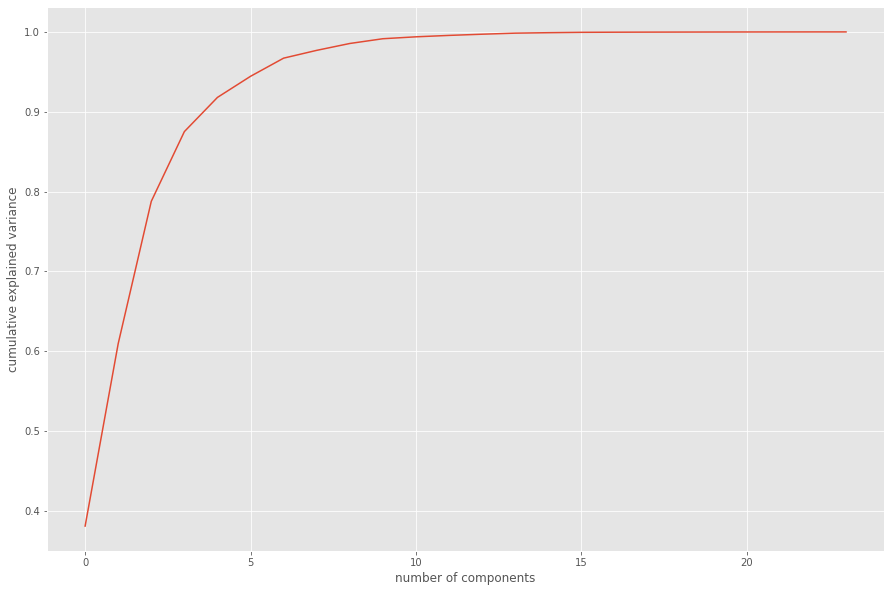

In [ ]:
# PCA
pca = PCA()
pca_traindata = pca.fit(df_rfe_train)

pca_traindata.explained_variance_
pca_traindata.n_components_
pcatrain = pca_traindata.transform(df_rfe_train)
pcatest = pca_traindata.transform(df_rfe_test)
cum_ratio = (np.cumsum(pca_traindata.explained_variance_ratio_))

# Visualize PCA result
plt.figure(figsize=(15,10))
plt.plot(np.cumsum(pca_traindata.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
# 21 features - constant after that
pca = PCA(n_components = 12)
pca_traindata = pca.fit(df_rfe_train)

pca_traindata.explained_variance_
pca_traindata.n_components_
pcatrain = pca_traindata.transform(df_rfe_train)
pcatest = pca_traindata.transform(df_rfe_test)
(np.cumsum(pca_traindata.explained_variance_ratio_))

array([0.3807804 , 0.60943144, 0.78772348, 0.87508997, 0.91793156,
       0.94437945, 0.96712293, 0.97689525, 0.98549928, 0.99145145,
       0.99385014, 0.99562078])

In [ ]:
# number of components
n_pcs= pca_traindata.components_.shape[0]
# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(pca_traindata.components_[i]).argmax() for i in range(n_pcs)]
print(most_important)
initial_feature_names = df_rfe_train.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}
print(dic)

[16, 10, 20, 15, 22, 23, 22, 3, 5, 8, 7, 6]
{'PC1': 'smooth_trend', 'PC2': 'sine', 'PC3': 'ADX_pol_weak', 'PC4': 'short_target', 'PC5': 'uptrend', 'PC6': 'RSI_pol', 'PC7': 'uptrend', 'PC8': 'ADX', 'PC9': 'AROONOSC', 'PC10': 'WILLR', 'PC11': 'ULTOSC', 'PC12': 'PLUS_DI'}


In [ ]:

# build the dataframe
df = pd.DataFrame(sorted(dic.items()))
df

,0,1
0,PC1,smooth_trend
1,PC10,WILLR
2,PC11,ULTOSC
3,PC12,PLUS_DI
4,PC2,sine
5,PC3,ADX_pol_weak
6,PC4,short_target
7,PC5,uptrend
8,PC6,RSI_pol
9,PC7,uptrend


In [ ]:
fina_df(dic.values())

dict_values(['smooth_trend', 'sine', 'ADX_pol_weak', 'short_target', 'uptrend', 'RSI_pol', 'uptrend', 'ADX', 'AROONOSC', 'WILLR', 'ULTOSC', 'PLUS_DI'])

In [ ]:
df_pca = final_df[['smooth_trend', 'sine', 'ADX_pol_weak', 'short_target', 'uptrend', 'RSI_pol', 'ADX', 'AROONOSC', 'WILLR', 'ULTOSC', 'PLUS_DI']]
#df_pca['trend_value'] = final_df['trend_value']
df_pca

,smooth_trend,sine,ADX_pol_weak,short_target,uptrend,RSI_pol,ADX,AROONOSC,WILLR,ULTOSC,PLUS_DI
timestamp,,,,,,,,,,,
2006-03-10,-0.113447,-0.857843,0,0.000000,0,0,0.334822,0.107143,0.070143,0.134409,0.108059
2006-03-13,-0.131893,-0.524970,0,0.290886,0,0,0.337251,0.107143,0.306161,0.225237,0.180415
2006-03-14,-0.141839,-0.257797,0,0.482477,0,0,0.329729,0.107143,0.461612,0.326260,0.219367
2006-03-15,-0.135822,-0.007278,0,0.355139,0,0,0.316241,0.107143,0.362069,0.347034,0.233174
2006-03-16,-0.135536,0.191196,0,0.135429,0,0,0.311194,0.142857,0.186936,0.241335,0.208050
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13,5.274001,0.111293,1,0.219673,0,0,0.180220,0.714286,0.260786,0.243610,0.299837
2021-09-14,5.232000,-0.261532,1,0.063388,0,0,0.171020,0.714286,0.123681,0.211125,0.258885
2021-09-15,4.352000,-0.670728,1,0.162842,0,0,0.165593,0.285714,0.244261,0.274897,0.231824


In [ ]:
pca_traindata.components_.shape

(12, 24)

In [ ]:
df_pca_cor = pd.DataFrame(pca_traindata.components_,index = ['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9','PC-10','PC-11','PC-12'])
df_pca_cor

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
PC-1,-0.152805,0.001541,0.000153,-0.021067,-0.025760,-0.229771,-0.120762,-0.102687,-0.180758,0.000709,0.084545,0.520558,-0.007901,0.009880,-0.000791,-0.120563,-0.628578,-0.002590,-0.000437,-0.000392,0.036291,-0.019877,-0.358467,0.216314
PC-2,-0.069816,0.002543,-0.001120,-0.013188,0.000637,-0.155633,-0.059551,-0.096113,-0.193813,-0.000004,-0.672295,-0.582265,-0.003394,0.010868,0.000275,-0.164715,-0.258470,-0.004011,-0.000231,-0.000042,0.025298,-0.013829,-0.151334,0.107441
PC-3,0.017772,0.000776,-0.000843,0.165915,-0.003247,-0.001082,0.014152,0.018315,-0.001918,0.000852,0.003413,-0.022196,0.016312,0.003627,0.000491,0.005068,-0.129807,0.000413,-0.000251,-0.000504,-0.690117,0.683100,-0.002397,-0.105124
PC-4,-0.116772,0.009215,0.000297,0.019164,0.015011,-0.012817,-0.069463,-0.115100,-0.287901,0.001719,0.152828,0.017222,-0.000263,0.049137,-0.000450,-0.658158,0.537312,-0.021128,-0.000919,-0.000196,-0.070847,0.055405,-0.334762,0.126547
PC-5,-0.034221,0.004427,-0.000029,-0.039256,-0.007521,0.187144,-0.020907,-0.045047,0.010367,-0.000706,0.240217,-0.168906,0.011980,0.015971,0.000833,-0.317332,-0.234662,-0.011356,-0.000084,0.000532,0.008570,0.065442,0.598563,0.595359
PC-6,-0.044879,-0.001820,0.000753,-0.038885,0.009400,-0.286435,-0.053553,-0.030507,0.053943,-0.000398,-0.371383,0.307075,-0.006844,-0.023205,-0.001708,0.356637,0.412722,0.007355,0.000407,-0.000192,-0.066994,0.124201,0.063079,0.594426
PC-7,-0.023222,0.001089,-0.000681,-0.087933,-0.001401,0.306484,-0.068353,0.052693,0.180852,0.004377,0.330149,-0.382106,-0.026394,-0.026544,-0.000757,0.329377,-0.025601,0.011051,-0.000361,-0.000612,0.035797,0.096144,-0.575424,0.387693
PC-8,0.021164,0.001206,0.000007,0.652016,0.003254,-0.086395,0.017240,-0.001516,0.011907,-0.000074,0.086200,-0.082691,0.034398,0.019958,0.002906,0.063825,-0.009546,-0.000137,-0.000761,0.000518,-0.432741,-0.580635,-0.032351,0.145041
PC-9,-0.061540,0.002987,0.003677,-0.093963,0.014204,-0.634615,-0.044760,-0.229190,-0.356291,0.004031,0.444944,-0.316805,0.009039,0.015043,-0.000477,0.271300,0.043456,0.004661,0.002577,0.001429,0.046840,0.059652,0.133361,-0.072275
PC-10,0.134728,0.000619,-0.005142,-0.027865,-0.010897,-0.543327,0.021787,0.469285,0.579191,-0.002735,0.084384,-0.106598,-0.027386,0.019159,0.000818,-0.309658,-0.031687,0.001544,-0.001985,-0.002628,0.047992,0.038629,-0.086175,0.042676


# Preparing Time-Series Data For LSTM

In [ ]:
y.index = df_pca.index
df_new = pd.concat([df_pca,y],axis=1)
#df_new['lag_trend_5'] = df_new['trend_xvalue'].shift(-5, axis = 0)
df_new

,smooth_trend,sine,ADX_pol_weak,short_target,uptrend,RSI_pol,ADX,AROONOSC,WILLR,ULTOSC,PLUS_DI,trend_xvalue
timestamp,,,,,,,,,,,,
2006-03-10,-0.113447,-0.857843,0,0.000000,0,0,0.334822,0.107143,0.070143,0.134409,0.108059,-0.500000
2006-03-13,-0.131893,-0.524970,0,0.290886,0,0,0.337251,0.107143,0.306161,0.225237,0.180415,-0.209114
2006-03-14,-0.141839,-0.257797,0,0.482477,0,0,0.329729,0.107143,0.461612,0.326260,0.219367,-0.017523
2006-03-15,-0.135822,-0.007278,0,0.355139,0,0,0.316241,0.107143,0.362069,0.347034,0.233174,-0.144861
2006-03-16,-0.135536,0.191196,0,0.135429,0,0,0.311194,0.142857,0.186936,0.241335,0.208050,-0.364571
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-13,5.274001,0.111293,1,0.219673,0,0,0.180220,0.714286,0.260786,0.243610,0.299837,0.719673
2021-09-14,5.232000,-0.261532,1,0.063388,0,0,0.171020,0.714286,0.123681,0.211125,0.258885,0.563388
2021-09-15,4.352000,-0.670728,1,0.162842,0,0,0.165593,0.285714,0.244261,0.274897,0.231824,0.662842


In [ ]:
col = list()
for i in range(5,0,-1):
  shift_df = df_new.shift(i,axis=0) 
  col.append(shift_df)

for i in range(0,1):
  shift_df = df_new.shift(-1,axis=0)
  col.append(shift_df) 

df_TS =pd.concat(col,axis=1)

In [ ]:
df_for_training = df_new[0:int(0.9*df_new.shape[0])]
df_for_testing = df_new[int(0.9*df_new.shape[0]):]
df_for_training_scaled = df_for_training.values
df_for_testing_scaled = df_for_testing.values
'''
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)
df_for_testing_scaled = scaler.transform(df_for_testing)
'''

trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 7  # Number of past days we want to use to predict the future.
print(len(df_for_training_scaled) - n_future +1)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    print((i - n_past,i),(0,(df_for_training.shape[1]-1)),(i + n_future - 1,i + n_future),(df_for_training.shape[1]-1))
    trainX.append(df_for_training_scaled[i - n_past:i, 0:(df_for_training.shape[1]-1)])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, (df_for_training.shape[1]-1)])
trainX, trainY = np.array(trainX), np.array(trainY)

testX,testY=[],[]
for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
    testX.append(df_for_testing_scaled[i - n_past:i, 0:(df_for_testing.shape[1]-1)])
    testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, (df_for_testing.shape[1]-1)])
testX, testY = np.array(testX), np.array(testY).astype(int)

In [ ]:
encoder_states1

In [ ]:
# n_features ==> no of features at each timestep in the data.

encoder_inputs = tf.keras.layers.Input(shape=(trainX.shape[1], trainX.shape[2]))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=False)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(trainX.shape[2]))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

ValueError: ignored

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(trainX,trainY,epochs=25,validation_split=0.2,batch_size=32,verbose=1,callbacks=[reduce_lr])

Epoch 1/25
67/67 [==============================] - 4s 19ms/step - loss: 0.2388 - val_loss: 0.2463
Epoch 2/25
67/67 [==============================] - 1s 8ms/step - loss: 0.2408 - val_loss: 0.2470
Epoch 3/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2402 - val_loss: 0.2450
Epoch 4/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2395 - val_loss: 0.2453
Epoch 5/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2398 - val_loss: 0.2480
Epoch 6/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2399 - val_loss: 0.2489
Epoch 7/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2390 - val_loss: 0.2461
Epoch 8/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2389 - val_loss: 0.2473
Epoch 9/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2392 - val_loss: 0.2449
Epoch 10/25
67/67 [==============================] - 0s 7ms/step - loss: 0.2392 - val_loss: 0.2457
Epoch 11/25
67/67 

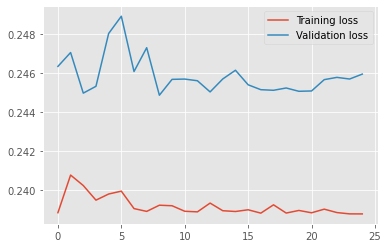

In [ ]:
plt.plot(history_e1d1.history['loss'], label='Training loss')
plt.plot(history_e1d1.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
#model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                12400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 12,451
Trainable params: 12,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit the model

history = model.fit(x = trainX, y = trainY,epochs=25, batch_size=16,validation_split=0.1, verbose=1)

Epoch 1/25
180/180 [==============================] - 3s 7ms/step - loss: 0.3004 - val_loss: 0.2264
Epoch 2/25
180/180 [==============================] - 1s 5ms/step - loss: 0.2347 - val_loss: 0.2130
Epoch 3/25
180/180 [==============================] - 1s 5ms/step - loss: 0.2159 - val_loss: 0.2191
Epoch 4/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1970 - val_loss: 0.1861
Epoch 5/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1895 - val_loss: 0.1787
Epoch 6/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1829 - val_loss: 0.1945
Epoch 7/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1812 - val_loss: 0.1790
Epoch 8/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1796 - val_loss: 0.2063
Epoch 9/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1773 - val_loss: 0.1897
Epoch 10/25
180/180 [==============================] - 1s 5ms/step - loss: 0.1765 - val_loss: 0.1884

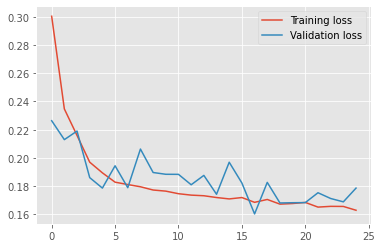

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

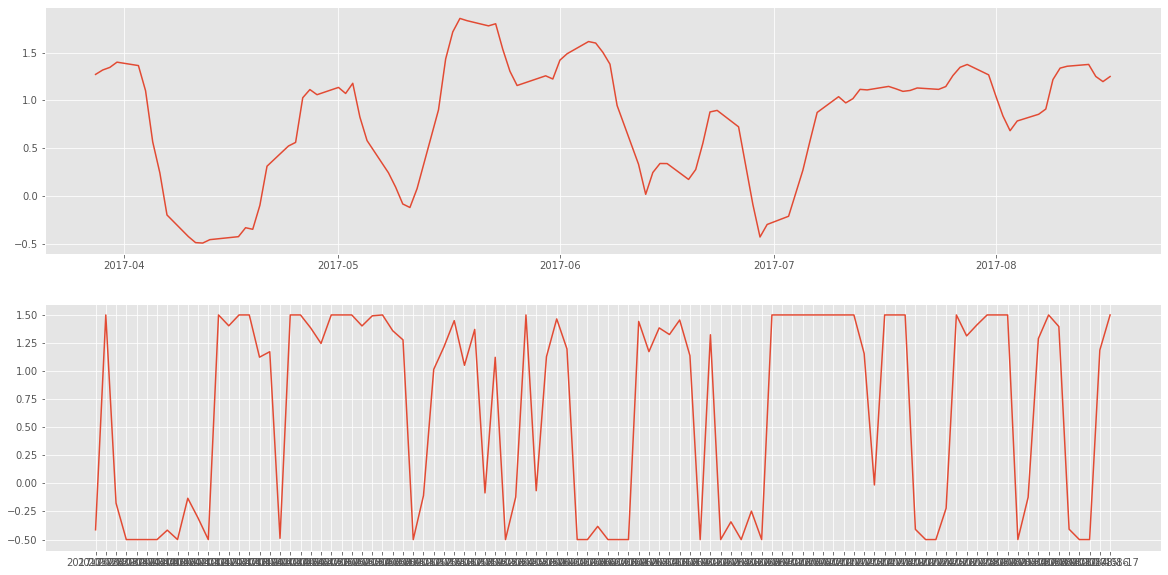

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df_forecast.Date,df_forecast.returns)
plt.subplot(2, 1, 2)
plt.plot(df_for_training['2017-03-28':'2017-08-17'].index,df_for_training['2017-03-28':'2017-08-17']['lag_trend_5'])
plt.show()

In [ ]:
df_forecast['y'] = df_for_training['trend_xvalue'][-n_days_for_prediction:].values
df_forecast

,Date,yhat,y
0,2017-03-28,0.331614,0.500000
1,2017-03-29,0.819379,0.500000
2,2017-03-30,0.974512,0.583744
3,2017-03-31,0.863903,0.500000
4,2017-04-03,0.661802,-0.132077
...,...,...,...
95,2017-08-11,1.426382,1.243684
96,2017-08-14,1.638602,1.456680
97,2017-08-15,1.148591,1.500000
98,2017-08-16,0.903294,1.500000


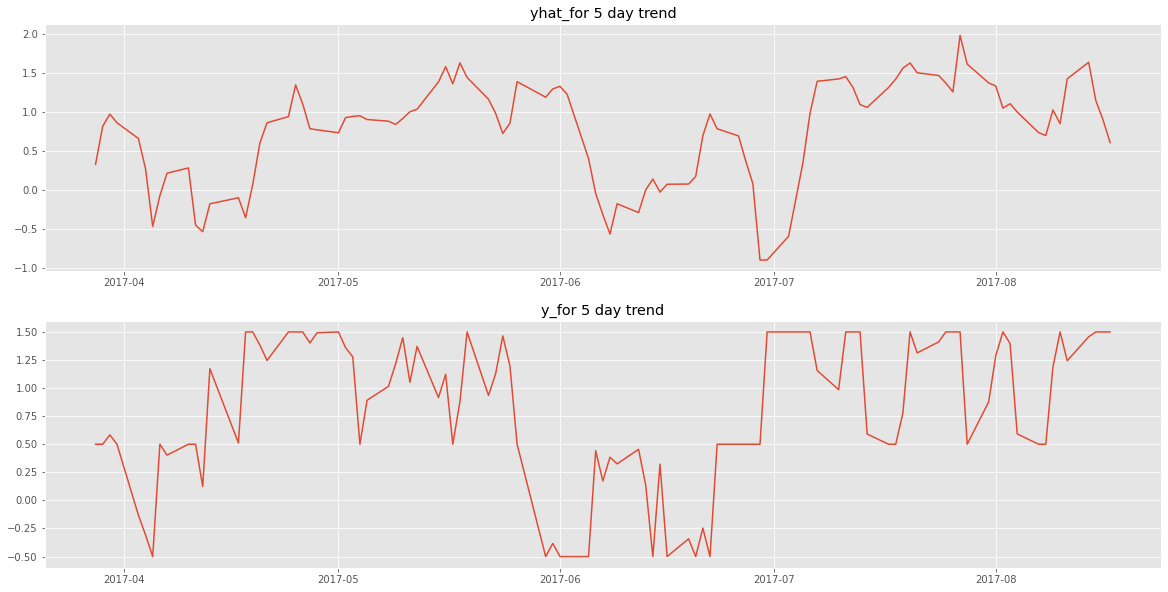

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df_forecast.Date,df_forecast.yhat)
plt.title("yhat_for 5 day trend")
plt.subplot(2, 1, 2)
plt.plot(df_forecast.Date,df_forecast.y)
plt.title("y_for 5 day trend")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


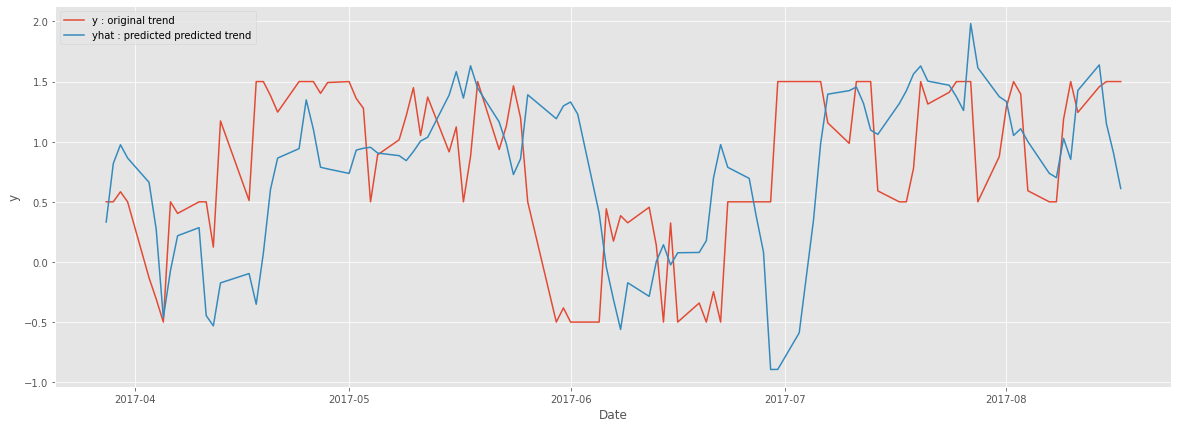

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['y'],label = 'y : original trend')
sns.lineplot(df_forecast['Date'], df_forecast['yhat'],label = 'yhat : predicted predicted trend')

In [ ]:
mean_absolute_percentage_error(df_forecast['y'],df_forecast['yhat'])

99.36419107299267

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 31
n_days_for_prediction=100

predict_period_dates = list(train_dates)[-n_days_for_prediction:]
#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

prediction = model.predict(trainX[-n_days_for_prediction:])
prediction = prediction.reshape(prediction.shape[0])

#prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'yhat':prediction})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])
df_forecast['y'] = df_for_training['trend_xvalue'][-n_days_for_prediction:].values
df_forecast

,Date,yhat,y
0,2017-03-28,1.026330,0.500000
1,2017-03-29,0.599707,0.500000
2,2017-03-30,0.553699,0.554140
3,2017-03-31,0.495237,0.500000
4,2017-04-03,0.097576,-0.290324
...,...,...,...
95,2017-08-11,1.125388,0.969247
96,2017-08-14,0.937556,1.103643
97,2017-08-15,1.064530,1.470385
98,2017-08-16,1.326031,1.500000


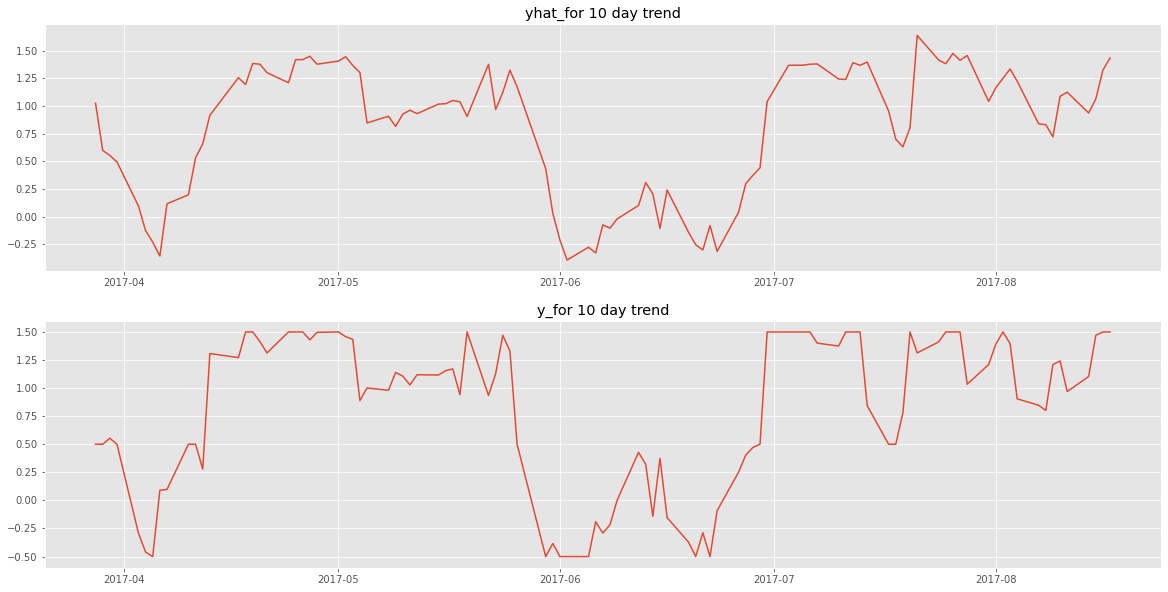

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df_forecast.Date,df_forecast.yhat)
plt.title("yhat_for 10 day trend")
plt.subplot(2, 1, 2)
plt.plot(df_forecast.Date,df_forecast.y)
plt.title("y_for 10 day trend")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


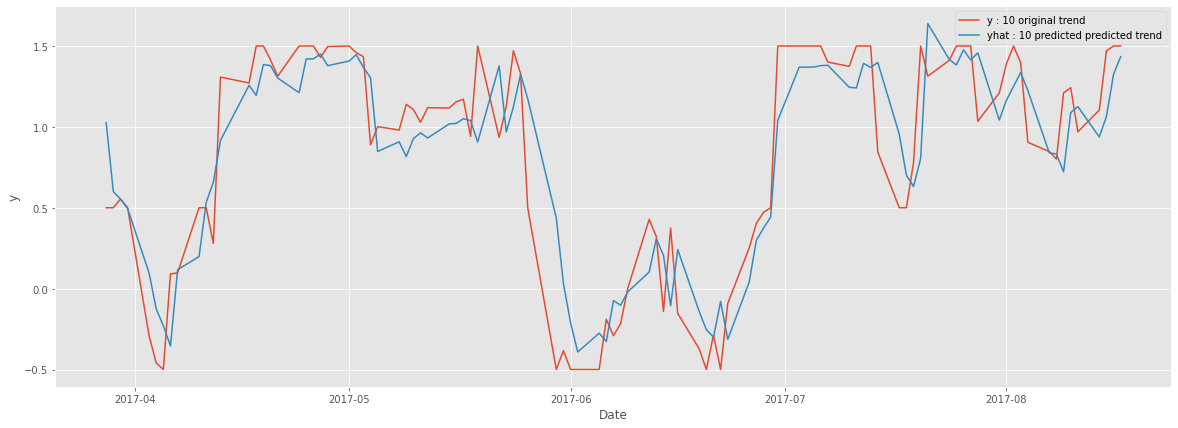

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['y'],label = 'y : 10 original trend')
sns.lineplot(df_forecast['Date'], df_forecast['yhat'],label = 'yhat : 10 predicted predicted trend')

In [ ]:
df_forecast['y'] = df_for_training['lag_trend_5'].loc['2017-03-28':'2017-08-17'].values
df_forecast

,Date,yhat,y
0,2017-03-28,1.210929,1.500000
1,2017-03-29,1.223197,0.824324
2,2017-03-30,1.223734,0.500000
3,2017-03-31,1.162934,0.500000
4,2017-04-03,1.027918,0.500000
...,...,...,...
95,2017-08-11,1.210264,0.847132
96,2017-08-14,1.280860,0.500000
97,2017-08-15,1.277202,1.085420
98,2017-08-16,1.305544,1.130977


In [ ]:
mean_absolute_percentage_error(df_forecast['y'],df_forecast['yhat'])

70.17841635670561

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 31
n_days_for_prediction=1000

predict_period_dates = list(train_dates)[-n_days_for_prediction:]
#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

prediction = model.predict(trainX[-n_days_for_prediction:])
prediction = prediction.reshape(prediction.shape[0])

#prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'yhat':prediction})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])
df_forecast['y'] = df_for_training['trend_xvalue'][-n_days_for_prediction:].values
df_forecast

,Date,yhat,y
0,2013-07-16,1.511072,1.500000
1,2013-07-17,1.491320,1.476987
2,2013-07-18,1.454052,1.500000
3,2013-07-19,1.483409,1.500000
4,2013-07-22,1.496439,1.500000
...,...,...,...
995,2017-08-11,1.393914,1.500000
996,2017-08-14,1.469340,1.500000
997,2017-08-15,1.470063,1.500000
998,2017-08-16,1.482492,1.500000


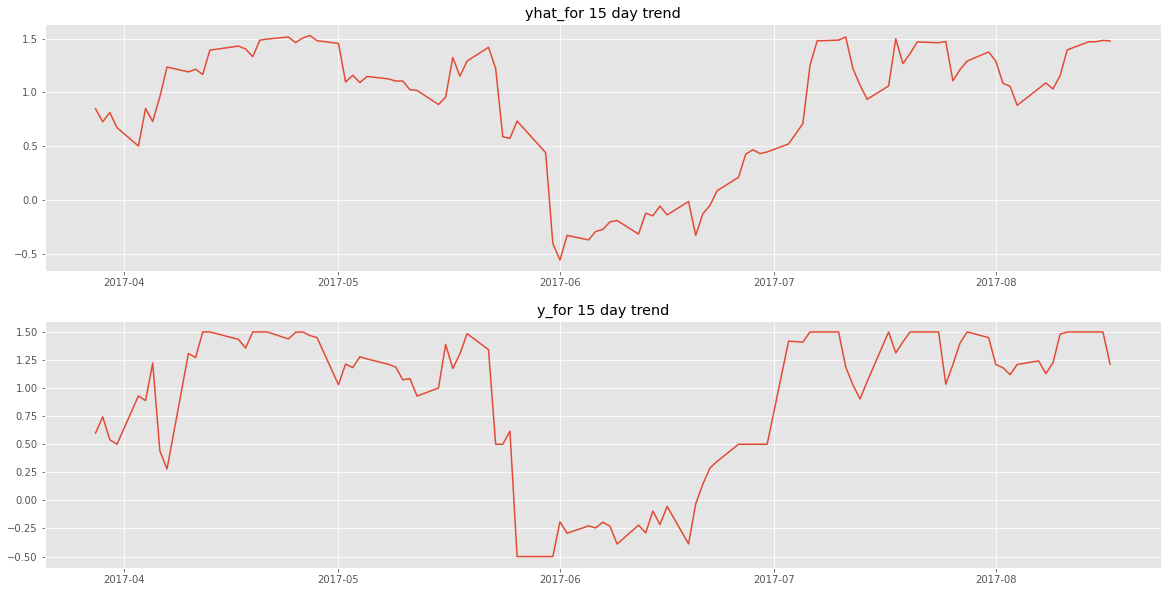

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(df_forecast.Date,df_forecast.yhat)
plt.title("yhat_for 15 day trend")
plt.subplot(2, 1, 2)
plt.plot(df_forecast.Date,df_forecast.y)
plt.title("y_for 15 day trend")
plt.show()

In [ ]:
df_forecast['close'] = df['close'].loc['2013-07-16':'2017-08-17'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


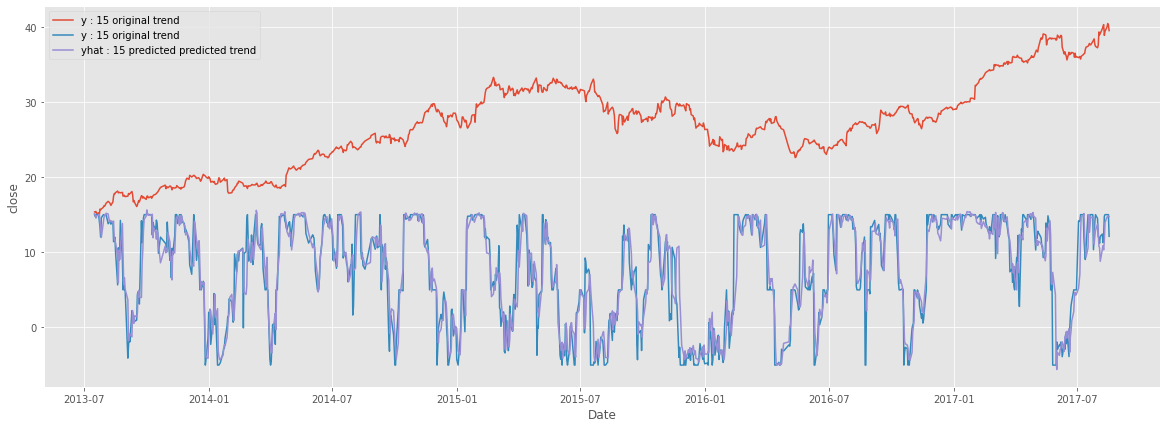

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['close'],label = 'y : 15 original trend')
sns.lineplot(df_forecast['Date'], df_forecast['y']*10,label = 'y : 15 original trend')
sns.lineplot(df_forecast['Date'], df_forecast['yhat']*10,label = 'yhat : 15 predicted predicted trend')

In [ ]:
%cd/content/drive/Shareddrives/Truinvest/NOTEBOOK

/content/drive/Shareddrives/Truinvest/NOTEBOOK


In [ ]:
df_forecast.to_csv('prediction_data.csv',index=True)

In [ ]:
mean_absolute_percentage_error(df_forecast['y'],df_forecast['yhat'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


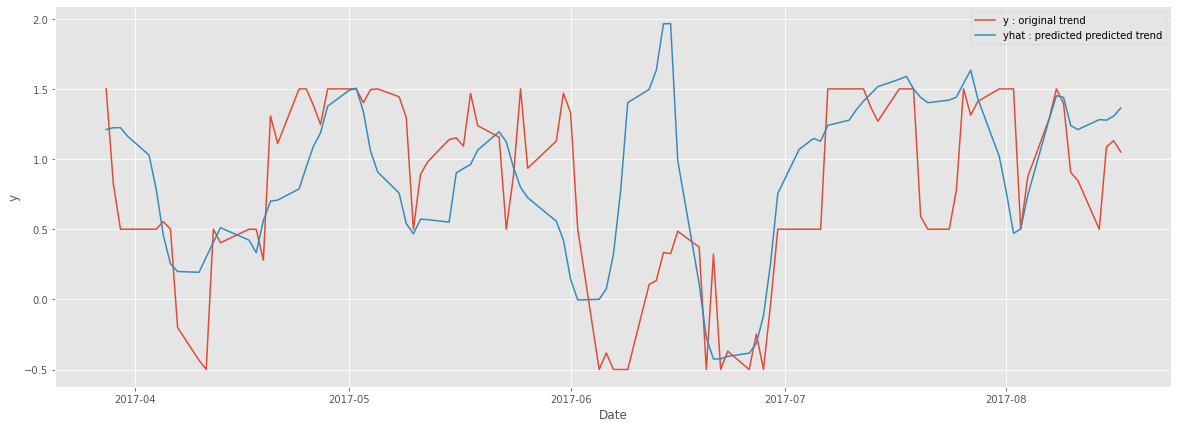

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['y'],label = 'y : original trend')
sns.lineplot(df_forecast['Date'], df_forecast['yhat'],label = 'yhat : predicted predicted trend')

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [ ]:
mean_absolute_percentage_error(df_forecast['y'],df_forecast['yhat'])

99.32242303693226

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 31
n_days_for_prediction=200

predict_period_dates = list(test_dates)[-n_days_for_prediction:]
#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

prediction = model.predict(testX[-n_days_for_prediction:])
prediction = prediction.reshape(prediction.shape[0])

#prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'yhat':prediction})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])
df_forecast['y'] = df_for_testing['trend_xvalue'][-n_days_for_prediction:].values
df_forecast

,Date,yhat,y
0,2020-11-24,0.734369,0.704651
1,2020-11-25,0.633107,0.837984
2,2020-11-27,0.781165,0.924806
3,2020-11-30,0.909720,1.306202
4,2020-12-01,1.358718,1.500000
...,...,...,...
195,2021-09-13,0.600688,0.719673
196,2021-09-14,0.560819,0.563388
197,2021-09-15,0.296863,0.662842
198,2021-09-16,0.344040,0.636612


In [ ]:
df_forecast['close'] = df['close'].loc['2020-11-24':'2021-09-17'].values

In [ ]:
df_forecast

,Date,yhat,y,close
0,2020-11-24,0.734369,0.704651,115.169998
1,2020-11-25,0.633107,0.837984,116.029999
2,2020-11-27,0.781165,0.924806,116.589996
3,2020-11-30,0.909720,1.306202,119.050003
4,2020-12-01,1.358718,1.500000,122.720001
...,...,...,...,...
195,2021-09-13,0.600688,0.719673,149.550003
196,2021-09-14,0.560819,0.563388,148.119995
197,2021-09-15,0.296863,0.662842,149.029999
198,2021-09-16,0.344040,0.636612,148.789993


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


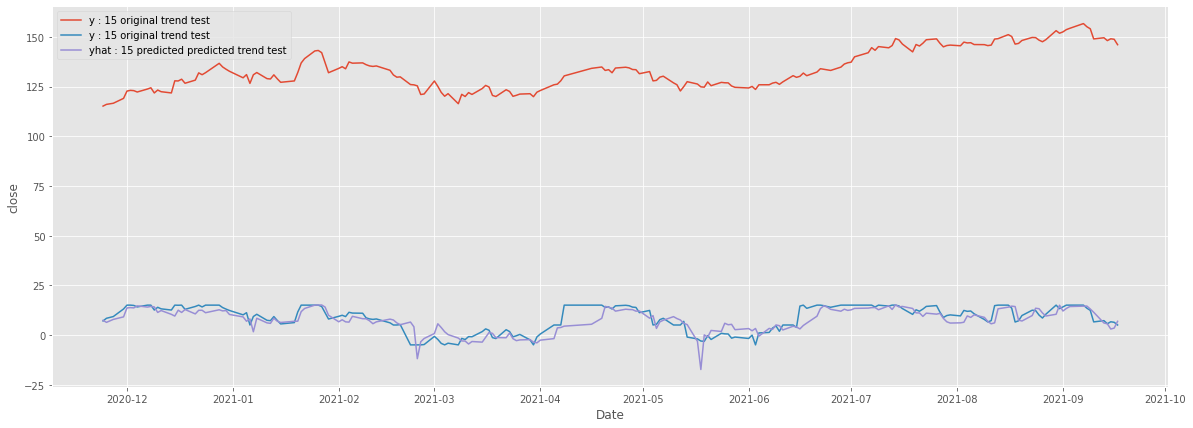

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['close'],label = 'y : 15 original trend test')
sns.lineplot(df_forecast['Date'], df_forecast['y']*10,label = 'y : 15 original trend test')
sns.lineplot(df_forecast['Date'], df_forecast['yhat']*10,label = 'yhat : 15 predicted predicted trend test')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


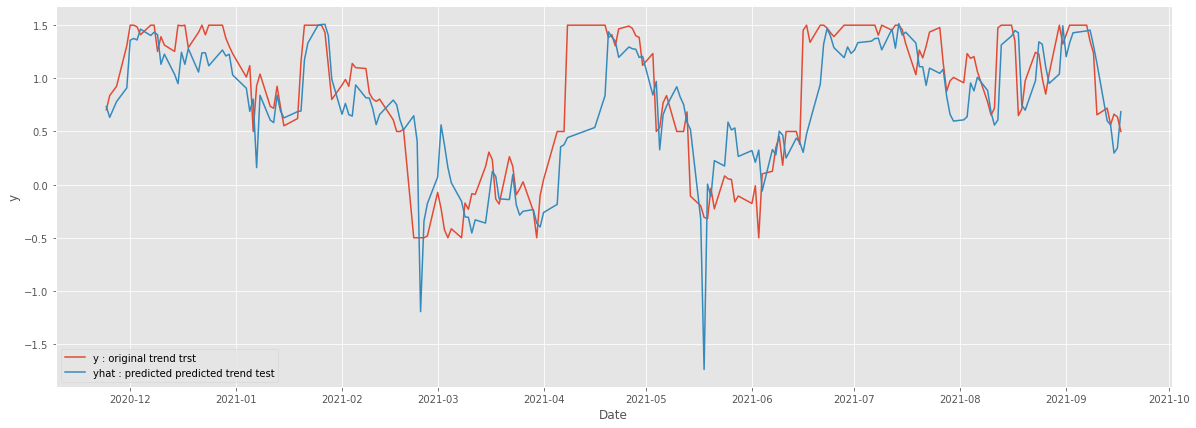

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['y'],label = 'y : original trend trst')
sns.lineplot(df_forecast['Date'], df_forecast['yhat'],label = 'yhat : predicted predicted trend test')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


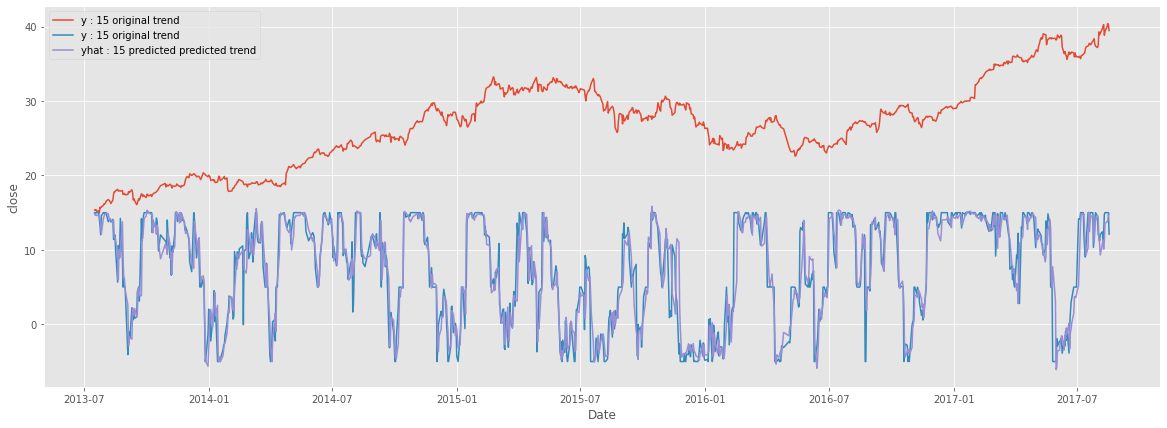

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['close'],label = 'y : 15 original trend')
sns.lineplot(df_forecast['Date'], df_forecast['y']*10,label = 'y : 15 original trend')
sns.lineplot(df_forecast['Date'], df_forecast['yhat']*10,label = 'yhat : 15 predicted predicted trend')

In [ ]:
66666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666666

**Lets try on varying the timesteps of the sequential input data of the LSTM verify the results 

Note: We will change the n_future : nth day in future from current date which we want to predict
and also n_past: nth day in past from current date which will be use to predict n_future value**

In [ ]:
# Predicting 15 day trend using 7 day past data for future 1 day

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 31
n_days_for_prediction=100

predict_period_dates = list(train_dates)[-n_days_for_prediction:]
#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

prediction = model.predict(trainX[-n_days_for_prediction:])
prediction = prediction.reshape(prediction.shape[0])

#prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'yhat':prediction})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])
df_forecast['y'] = df_for_training['trend_xvalue'][-n_days_for_prediction:].values
df_forecast

,Date,yhat,y
0,2019-07-31,0.779948,0.789340
1,2019-08-01,0.876204,1.012183
2,2019-08-02,1.062329,0.888325
3,2019-08-05,0.820148,-0.137563
4,2019-08-06,0.356083,0.293401
...,...,...,...
95,2019-12-16,1.479664,1.500000
96,2019-12-17,1.521615,1.500000
97,2019-12-18,1.510396,1.500000
98,2019-12-19,1.515051,1.495215


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


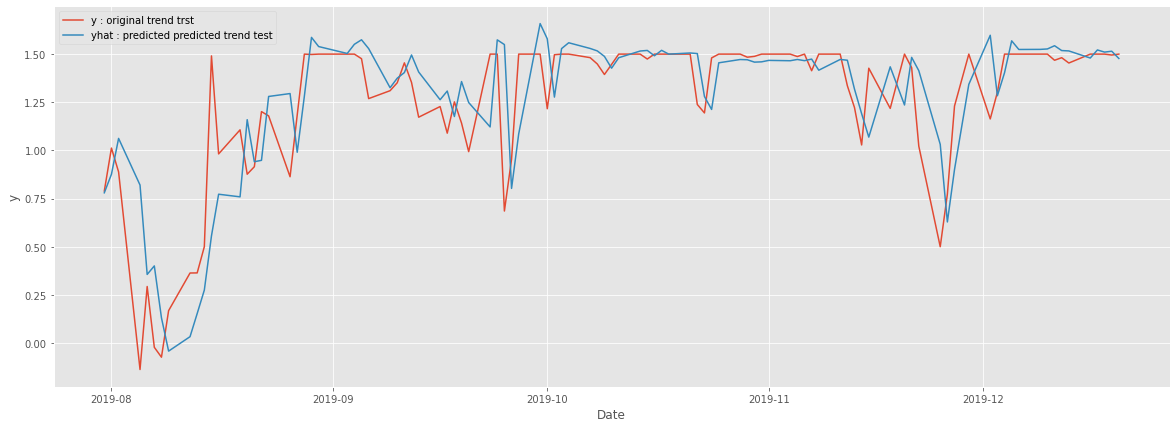

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['y'],label = 'y : original trend trst')
sns.lineplot(df_forecast['Date'], df_forecast['yhat'],label = 'yhat : predicted predicted trend test')

In [ ]:
mean_absolute_percentage_error(df_forecast['y'],df_forecast['yhat'])

43.83798188331361

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 31
n_days_for_prediction=100

predict_period_dates = list(test_dates)[-n_days_for_prediction:]
#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

prediction = model.predict(testX[-n_days_for_prediction:])
prediction = prediction.reshape(prediction.shape[0])

#prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'yhat':prediction})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])
df_forecast['y'] = df_for_testing['trend_xvalue'][-n_days_for_prediction:].values
df_forecast

,Date,yhat,y
0,2021-04-28,1.217581,1.400710
1,2021-04-29,1.159848,1.385135
2,2021-04-30,1.126139,1.121925
3,2021-05-03,1.006951,1.233487
4,2021-05-04,1.036493,0.500000
...,...,...,...
95,2021-09-13,0.850216,0.719673
96,2021-09-14,0.917069,0.563388
97,2021-09-15,0.820016,0.662842
98,2021-09-16,0.871542,0.636612


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


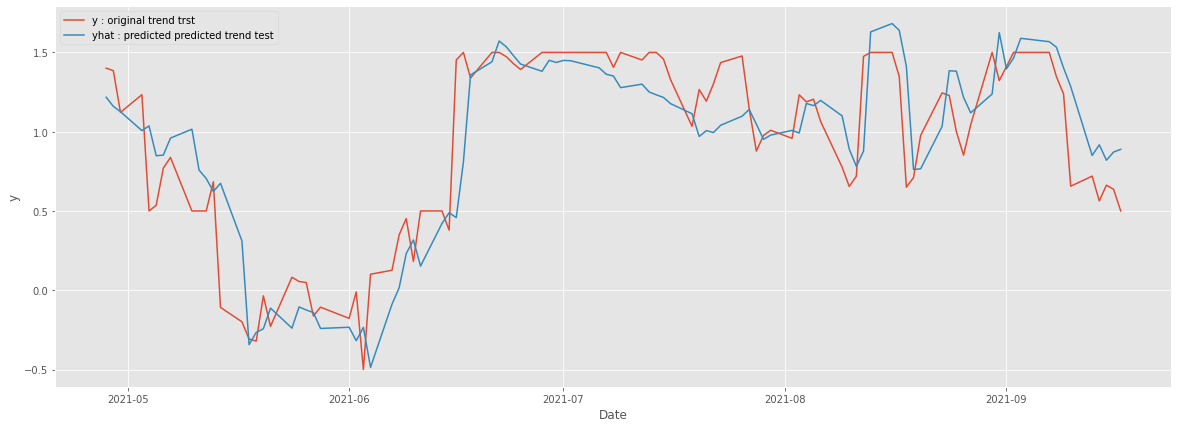

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_forecast['Date'], df_forecast['y'],label = 'y : original trend trst')
sns.lineplot(df_forecast['Date'], df_forecast['yhat'],label = 'yhat : predicted predicted trend test')

In [ ]:
mean_absolute_percentage_error(df_forecast['y'],df_forecast['yhat'])

86.01571565247478

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
n_past = 31
n_days_for_prediction=100

predict_period_dates = list(train_dates)[-n_days_for_prediction:]
#predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

prediction = model.predict(trainX[-n_days_for_prediction:])
prediction = prediction.reshape(prediction.shape[0])

#prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
#y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())

    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'returns':prediction})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])

start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])

#df = pd.read_csv('alpha_features')
#df = df.dropna()

original = df_for_training['lag_trend_5']
original['timestamp']=df_for_training.index
#original.reset_index(inplace = True, drop = True)
df_predicted = original.loc[original["timestamp"].isin(pd.date_range(start_date, end_date))]
df_predicted.reset_index(inplace = True, drop = True)
df_predicted['yaht'] = list(df_forecast['returns'])
df_predicted = df_predicted.set_axis(["timestamp", "y","yhat"], axis=1)
df_predicted.to_csv(str(n_days_for_prediction)+'yaht_train14',index =False)
df_predicted
#print('files generated')

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


IndexError: ignored

In [ ]:
df = pd.read_csv('alpha_features')
df.Target

0        0
1        0
2        1
3        1
4        1
        ..
10263    1
10264    0
10265    0
10266    0
10267    0
Name: Target, Length: 10268, dtype: int64

/home/pranav/algo_trade/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pranav/algo_trade/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='timestamp', ylabel='y'>

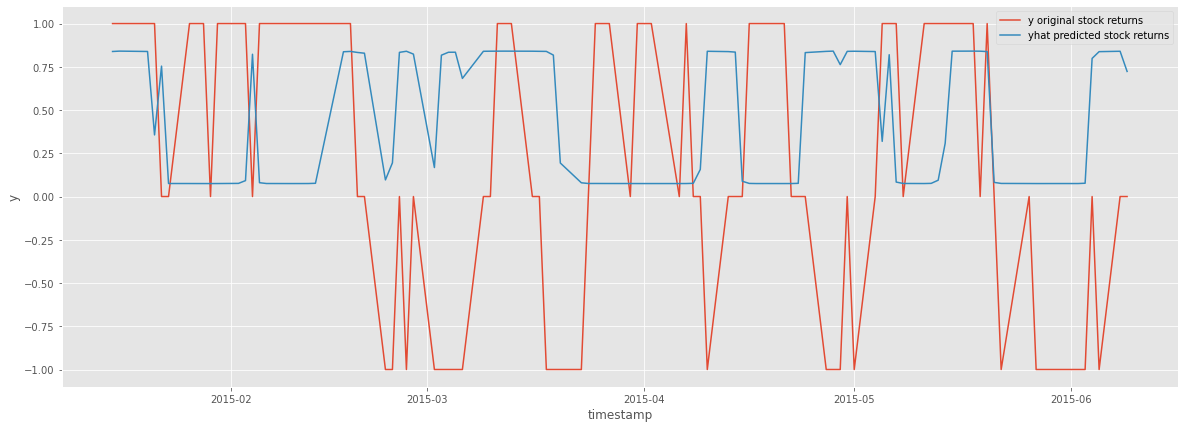

In [ ]:
plt.figure(figsize=(20, 7))
sns.lineplot(df_predicted['timestamp'], df_predicted['y'],label = 'y original stock returns')
sns.lineplot(df_predicted['timestamp'], df_predicted['yhat'],label = 'yhat predicted stock returns')

# Remember to measure relative entropy between yhat and y

In [ ]:
#Hyper-parameter-tuning
class HPT:
  def __init__(self):
    self.mape = {}
    self.y = {}
    self.yhat = {}
    self.val_los = {}
    self.train_los = {}
  
  def sequence_data(df,n_past,n_future):
    df_for_training = df_new[0:int(0.9*df_new.shape[0])]
    df_for_testing = df_new[int(0.9*df_new.shape[0]):]
    df_for_training_scaled = df_for_training.values
    df_for_testing_scaled = df_for_testing.values
  
    trainX = []
    trainY = []

    #n_future = 1   # Number of days we want to look into the future based on the past days.
    #n_past = 7  # Number of past days we want to use to predict the future.
    print(len(df_for_training_scaled) - n_future +1)
    for i in range(n_past, len(df_for_training_scaled) - n_future +1):
        print((i - n_past,i),(0,(df_for_training.shape[1]-1)),(i + n_future - 1,i + n_future),(df_for_training.shape[1]-1))
        trainX.append(df_for_training_scaled[i - n_past:i, 0:(df_for_training.shape[1]-1)])
        trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, (df_for_training.shape[1]-1)])
    trainX, trainY = np.array(trainX), np.array(trainY)

    testX,testY=[],[]
    for i in range(n_past, len(df_for_testing_scaled) - n_future +1):
        testX.append(df_for_testing_scaled[i - n_past:i, 0:(df_for_testing.shape[1]-1)])
        testY.append(df_for_testing_scaled[i + n_future - 1:i + n_future, (df_for_testing.shape[1]-1)])
    testX, testY = np.array(testX), np.array(testY).astype(int)
    return trainX,trainY,testX,testY

  def model_lstm(trainX,trainY,n_epochs,batch):
    # fit the model
    model = Sequential()
    model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2])))
    #model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(trainY.shape[1]))
    model.compile(optimizer='adam', loss='mae')
    model.summary()
    history = model.fit(x = trainX, y = trainY,epochs=n_epochs, batch_size=batch,validation_split=0.1, verbose=1)
    self.val_los['timestep'+str(n_past)] = history.history['val_loss']
    self.train_los['timestep'+str(n_past)] = history.history['loss']
    
  def predicting(model,history):
    n_past = 31
    n_days_for_prediction = 300
    predict_period_dates = list(test_dates)[-n_days_for_prediction:]
    #predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction,freq = us_bd).tolist()

    prediction = model.predict(testX[-n_days_for_prediction:])
    prediction = prediction.reshape(prediction.shape[0])
    #prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
    #y_pred_future = scaler.inverse_transform(prediction_copies)[:,(prediction_copies.shape[1]-1)]

    forecast_dates = []
    for time_i in predict_period_dates:
        forecast_dates.append(time_i.date())

    df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'yhat':prediction})
    df_forecast['Date']=pd.to_datetime(df_forecast['Date'])
    start_date,end_date = str(forecast_dates[0]),str(forecast_dates[-1])
    df_forecast['y'] = df_for_testing['trend_xvalue'][-n_days_for_prediction:].values
    return df_forecast
    


In [ ]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

###### is increasing
incr = df.diff().ge(0)

In [ ]:


# is increasing
incr = df.diff().ge(0)

# shifted trend (local minima)
shifted = incr.ne(incr.shift())

# local max
local_max = shifted & (~incr)

# thresholding function
def thresh(x, threshold=3, step=2):
    ret = pd.Series([0]*len(x), index=x.index)
    t = x.min() + threshold
    ret.loc[x.gt(t)] = step
    return ret

signal = s.groupby(local_max.cumsum()).apply(thresh)
signal += s.min()

# draw
fig, ax = plt.subplots(figsize=(10,6))
df.plot(ax=ax)
signal.plot(drawstyle='steps', ax=ax)
plt.show()

NameError: ignored

In [ ]:
df = pd.read_csv('100yaht_train14')
df

,timestamp,y,yhat
0,2018-01-02,0.017905,0.003474
1,2018-01-03,-0.000174,0.003474
2,2018-01-04,0.004645,0.003474
3,2018-01-05,0.011385,0.003472
4,2018-01-08,-0.003714,0.003458
...,...,...,...
95,2018-05-18,-0.003637,0.002699
96,2018-05-21,0.007085,-0.006621
97,2018-05-22,-0.002505,0.003518
98,2018-05-23,0.006412,0.003474


<AxesSubplot:>

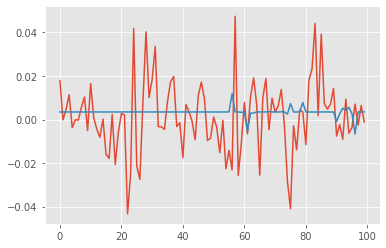

In [ ]:
df['y'].plot()
df['yhat'].plot()
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
Code:

import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

In [ ]:
df['yhat'].describe()

count    100.000000
mean       0.003415
std        0.001783
min       -0.006621
25%        0.003474
50%        0.003474
75%        0.003474
max        0.011825
Name: yhat, dtype: float64

<AxesSubplot:xlabel='y', ylabel='Count'>

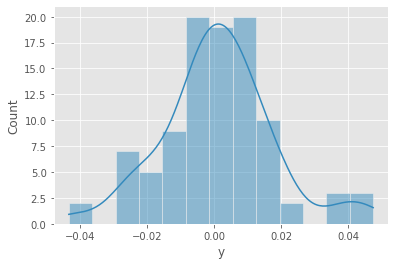

In [ ]:
sns.histplot(df['y'],kde=True)

In [ ]:
sns.histplot(df['yhat'],kde=True)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/pranav/algo_trade/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_143834/2650509605.py", line 1, in <module>
    sns.histplot(df['yhat'],kde=True)
  File "/home/pranav/algo_trade/lib/python3.8/site-packages/seaborn/distributions.py", line 1423, in histplot
    p.plot_univariate_histogram(
  File "/home/pranav/algo_trade/lib/python3.8/site-packages/seaborn/distributions.py", line 555, in plot_univariate_histogram
    artists = plot_func(
  File "/home/pranav/algo_trade/lib/python3.8/site-packages/matplotlib/__init__.py", line 1361, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "/home/pranav/algo_trade/lib/python3.8/site-packages/matplotlib/axes/_axes.py", line 2371, in bar
    self.add_patch(r)
  File "/home/pranav/algo_trade/lib/python3.8/site-packages/matplotlib/axes/_base.py", line 2170, in a

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x7f82463f9430> (for post_execute):


KeyboardInterrupt: 

In [ ]:

plt.hist(df['y'], bins=10)
plt.show()

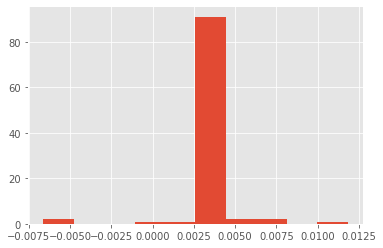

In [ ]:
plt.hist(df['yhat'], density=False,bins=10)
plt.show()

KeyboardInterrupt: 

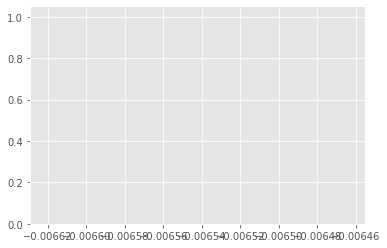

In [ ]:
sns.histplot(data=df['yhat'],kde=True)

In [ ]:
sns.histplot(data=df['y'],kde=True)

In [ ]:
signal  = []
for i in range(len(df)):
    if(df['y'].loc[i]>0 and df['yhat'].loc[i]>0):
        signal.append(1)
    elif(df['y'].loc[i]<0 and df['yhat'].loc[i]<0):
        signal.append(-1)
    elif(df['y'].loc[i]>=0 and df['yhat'].loc[i]<=0):
        signal.append(-2)
    elif(df['y'].loc[i]<=0 and df['yhat'].loc[i]>=0):
        signal.append(2)
df['signal'] = signal
df['signal'].value_counts()

 1    50
 2    47
-1     2
-2     1
Name: signal, dtype: int64

In [ ]:
conf_mat = pd.DataFrame(data={'yhat>0':[df['signal'].value_counts()[1],df['signal'].value_counts()[2]],'yhat<0':[df['signal'].value_counts()[-2],df['signal'].value_counts()[-1]]},index=['y>0','y<0'])
conf_mat

,yhat>0,yhat<0
y>0,50,1
y<0,47,2


In [ ]:
52/